<a href="https://colab.research.google.com/github/Chandralekha005/machine-learning/blob/main/Road_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sakshaymahna/kittiroadsegmentation")

print("Path to dataset files:", path)

100%|██████████| 305M/305M [00:08<00:00, 37.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sakshaymahna/kittiroadsegmentation/versions/1


# Fully Convolutional Network

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import cv2
from tqdm import tqdm
import datetime
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.layers import Input, Add, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline

from IPython.display import HTML
from base64 import b64encode

### Source Dataset

In [ ]:
# Load directories
train_data_dir = "../input/kittiroadsegmentation/training/image_2/"
train_gt_dir = "../input/kittiroadsegmentation/training/gt_image_2/"

test_data_dir = "../input/kittiroadsegmentation/testing/"

In [ ]:
import os

# Get the current working directory
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

# List files and directories in the current directory
contents = os.listdir(current_directory)
print(f"Contents of current directory: {contents}")

# Update the path to the data directory accordingly
train_data_dir = "/root/.cache/kagglehub/datasets/sakshaymahna/kittiroadsegmentation/versions/1"  # Update with the correct path

# Number of training examples
TRAINSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.8)
print(f"Number of Training Examples: {TRAINSET_SIZE}")

VALIDSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.1)
print(f"Number of Validation Examples: {VALIDSET_SIZE}")

TESTSET_SIZE = int(len(os.listdir(train_data_dir)) - TRAINSET_SIZE - VALIDSET_SIZE)
print(f"Number of Testing Examples: {TESTSET_SIZE}")

Current working directory: /content
Contents of current directory: ['.config', 'sample_data']
Number of Training Examples: 1
Number of Validation Examples: 0
Number of Testing Examples: 1


In [ ]:
# Initialize Constants
IMG_SIZE = 224
N_CHANNELS = 3
N_CLASSES = 1
SEED = 123
os.getcwd()

'/content'

In [ ]:
# Function to load image and return a dictionary
def parse_image(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # Three types of img paths: um, umm, uu
    # gt image paths: um_road, umm_road, uu_road
    mask_path = tf.strings.regex_replace(img_path, "image_2", "gt_image_2")
    mask_path = tf.strings.regex_replace(mask_path, "um_", "um_road_")
    mask_path = tf.strings.regex_replace(mask_path, "umm_", "umm_road_")
    mask_path = tf.strings.regex_replace(mask_path, "uu_", "uu_road_")

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)

    non_road_label = np.array([255, 0, 0])
    road_label = np.array([255, 0, 255])
    other_road_label = np.array([0, 0, 0])

    # Convert to mask to binary mask
    mask = tf.experimental.numpy.all(mask == road_label, axis = 2)
    mask = tf.cast(mask, tf.uint8)
    mask = tf.expand_dims(mask, axis=-1)

    return {'image': image, 'segmentation_mask': mask}

In [ ]:
import os
import tensorflow as tf
import numpy as np

# Get the current working directory
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

# List files and directories in the current directory
contents = os.listdir(current_directory)
print(f"Contents of current directory: {contents}")

# Update the path to the data directory accordingly
# Include the subdirectory where the images are located
train_data_dir = "/root/.cache/kagglehub/datasets/sakshaymahna/kittiroadsegmentation/versions/1/training/image_2/"  # Updated with the correct path, including subdirectory

# Number of training examples
# We need to count the files in the correct subdirectory
TRAINSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.8)
print(f"Number of Training Examples: {TRAINSET_SIZE}")

VALIDSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.1)
print(f"Number of Validation Examples: {VALIDSET_SIZE}")

TESTSET_SIZE = int(len(os.listdir(train_data_dir)) - TRAINSET_SIZE - VALIDSET_SIZE)
print(f"Number of Testing Examples: {TESTSET_SIZE}")

Current working directory: /content
Contents of current directory: ['.config', 'sample_data']
Number of Training Examples: 231
Number of Validation Examples: 28
Number of Testing Examples: 30


In [ ]:
# Generate dataset variables
all_dataset = tf.data.Dataset.list_files(train_data_dir + "*.png", seed=SEED)
all_dataset = all_dataset.map(parse_image)

train_dataset = all_dataset.take(TRAINSET_SIZE + VALIDSET_SIZE)
val_dataset = train_dataset.skip(TRAINSET_SIZE)
train_dataset = train_dataset.take(TRAINSET_SIZE)
test_dataset = all_dataset.skip(TRAINSET_SIZE + VALIDSET_SIZE)

### Apply Transformations

In [ ]:
# Tensorflow function to rescale images to [0, 1]
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

# Tensorflow function to apply preprocessing transformations
@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# Tensorflow function to preprocess validation images
@tf.function
def load_image_test(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

BATCH_SIZE = 32
BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset, "test": test_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=tf.data.AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=tf.data.AUTOTUNE)

#-- Testing Dataset --#
dataset['test'] = dataset['test'].map(load_image_test)
dataset['test'] = dataset['test'].batch(BATCH_SIZE)
dataset['test'] = dataset['test'].prefetch(buffer_size=tf.data.AUTOTUNE)

print(dataset['train'])
print(dataset['val'])
print(dataset['test'])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>


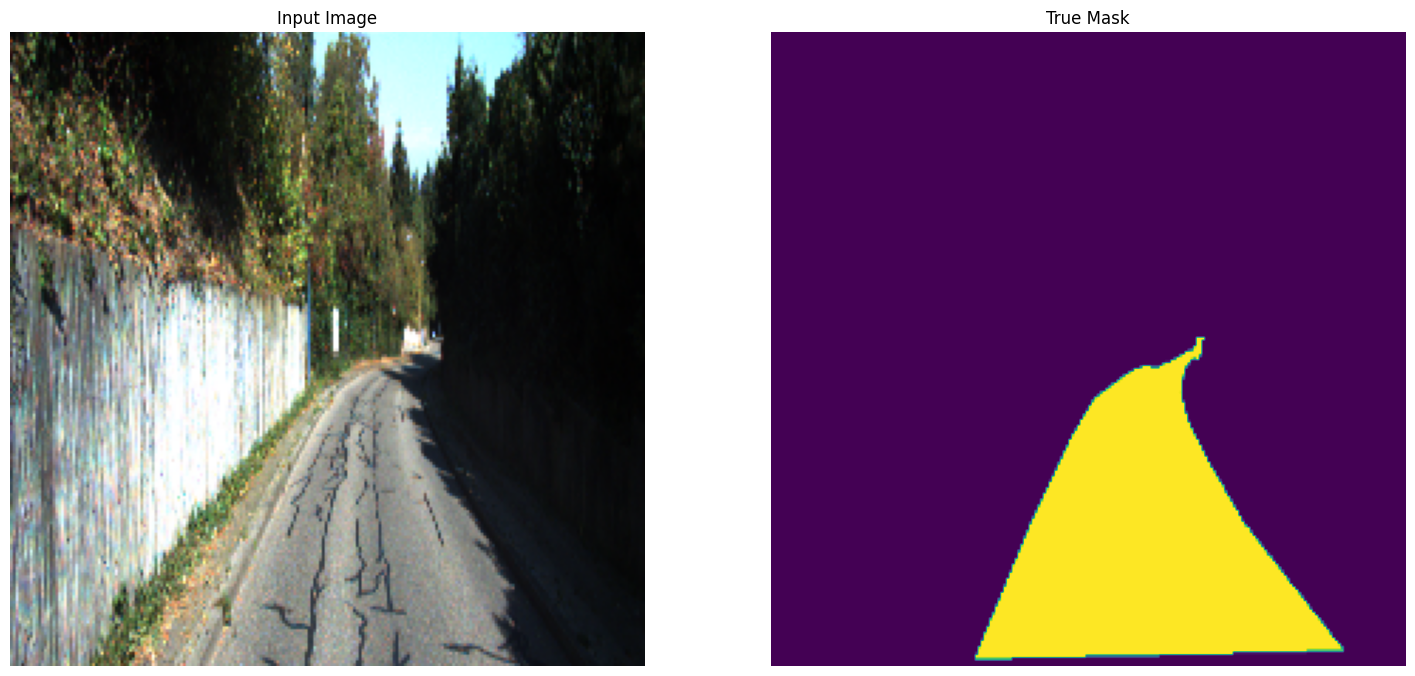

In [ ]:
# Function to view the images from the directory
def display_sample(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.show()

for image, mask in dataset["train"].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

## Define Network

In [ ]:
!pip install tensorflow # Install TensorFlow if not already installed.
import tensorflow as tf

# Import the VGG16 model from Keras
from tensorflow.keras.applications import VGG16

# Get VGG-16 network as backbone
vgg16_model = VGG16()
vgg16_model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define input shape
IMG_SIZE = 224  # Define IMG_SIZE with a desired value.
N_CHANNELS = 3  # Define N_CHANNELS with a desired value.
input_shape = (IMG_SIZE, IMG_SIZE, N_CHANNELS)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input

# Define the input shape
input_shape = (224, 224, 3)  # Example input shape for VGG16 (image height, width, channels)

# Input layer
inputs = Input(shape=input_shape)

# VGG16 network
vgg16_model = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Encoder Layers
c1 = vgg16_model.get_layer("block3_pool").output
c2 = vgg16_model.get_layer("block4_pool").output
c3 = vgg16_model.get_layer("block5_pool").output


In [ ]:
from tensorflow.keras.layers import UpSampling2D, Concatenate # Import necessary layers


# Decoder
u1 = UpSampling2D((2, 2), interpolation='bilinear')(c3) # Use UpSampling2D from Keras
d1 = Concatenate()([u1, c2])

u2 = UpSampling2D((2, 2), interpolation='bilinear')(d1) # Use UpSampling2D from Keras
d2 = Concatenate()([u2, c1])

In [ ]:
from tensorflow.keras.layers import UpSampling2D, Concatenate, Conv2D  # Import Conv2D along with others
from tensorflow.keras.models import Model
N_CLASSES = 2
# Output
u3 = UpSampling2D((8, 8), interpolation = 'bilinear')(d2)
output = Conv2D( N_CLASSES, 1, activation = 'sigmoid')(u3) # Now Conv2D is defined

model = Model(inputs, output, name = "VGG_FCN8")

In [ ]:
import os
import kagglehub
print(os.path.exists(kagglehub.dataset_download("sakshaymahna/kittiroadsegmentation")))


True


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the ImageDataGenerator objects for data augmentation and rescaling
train_data_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split 20% of data for validation
)

# Creating the train and validation generators
train_generator = train_data_gen.flow_from_directory(
    '/root/.cache/kagglehub/datasets/sakshaymahna/kittiroadsegmentation/versions/1',  # Replace with your dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Use the training subset
)

val_generator = train_data_gen.flow_from_directory(
    '/root/.cache/kagglehub/datasets/sakshaymahna/kittiroadsegmentation/versions/1',  # Replace with your dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Use the validation subset
)

# Define your model (example model structure)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Calculate steps per epoch
train_steps_per_epoch = train_generator.samples // train_generator.batch_size
val_steps_per_epoch = val_generator.samples // val_generator.batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    epochs=20,  # Adjust the number of epochs as needed
    callbacks=callbacks
)

# Save the final model
model.save("final_autonomous_driving_model.keras")

# Evaluate the model
loss, accuracy = model.evaluate(val_generator, steps=val_steps_per_epoch)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")


Found 539 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 1.0000 - loss: 0.1256 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/20
 1/16 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - accuracy: 1.0000 - loss: 0.0000e+00

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 598ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00
Validation Loss: 0.0000, Validation Accuracy: 1.0000


Found 134 images belonging to 2 classes.


### Loss Function

In [ ]:
m_iou = tf.keras.metrics.MeanIoU(2)
model.compile(optimizer=Adam(),
              loss=BinaryCrossentropy(),
              metrics=[m_iou])

### Check Model

Found 539 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step


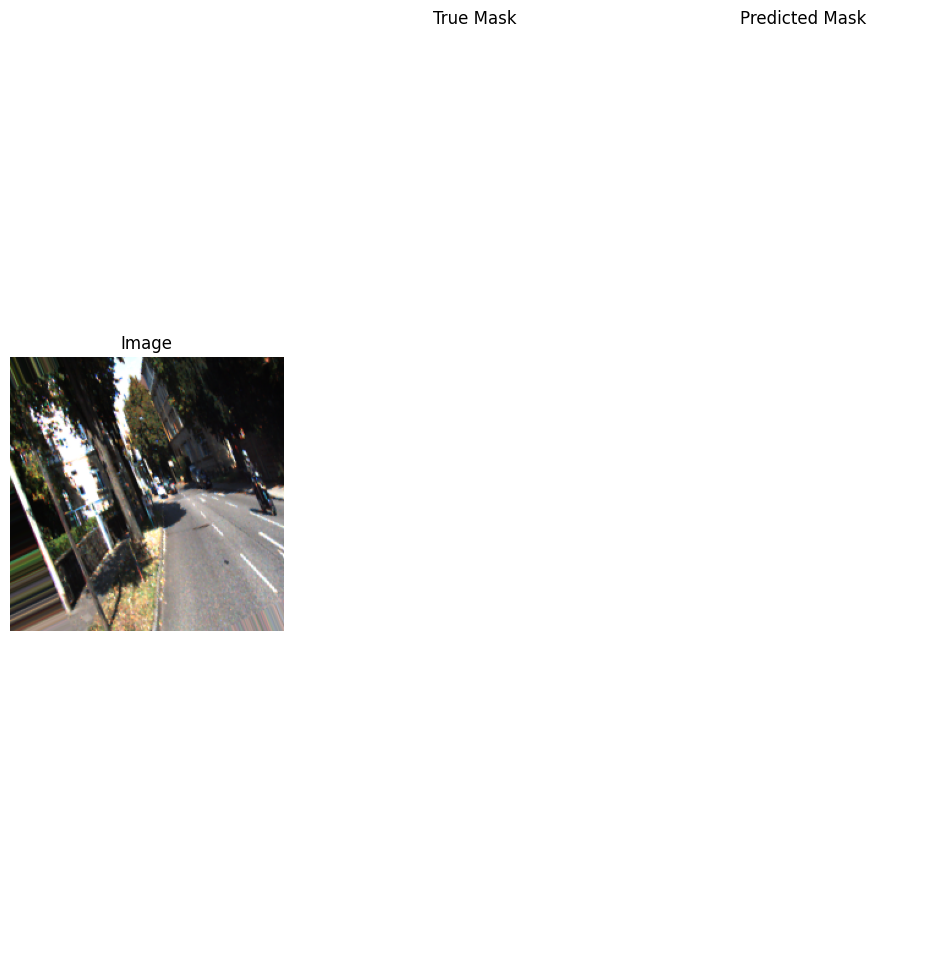

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


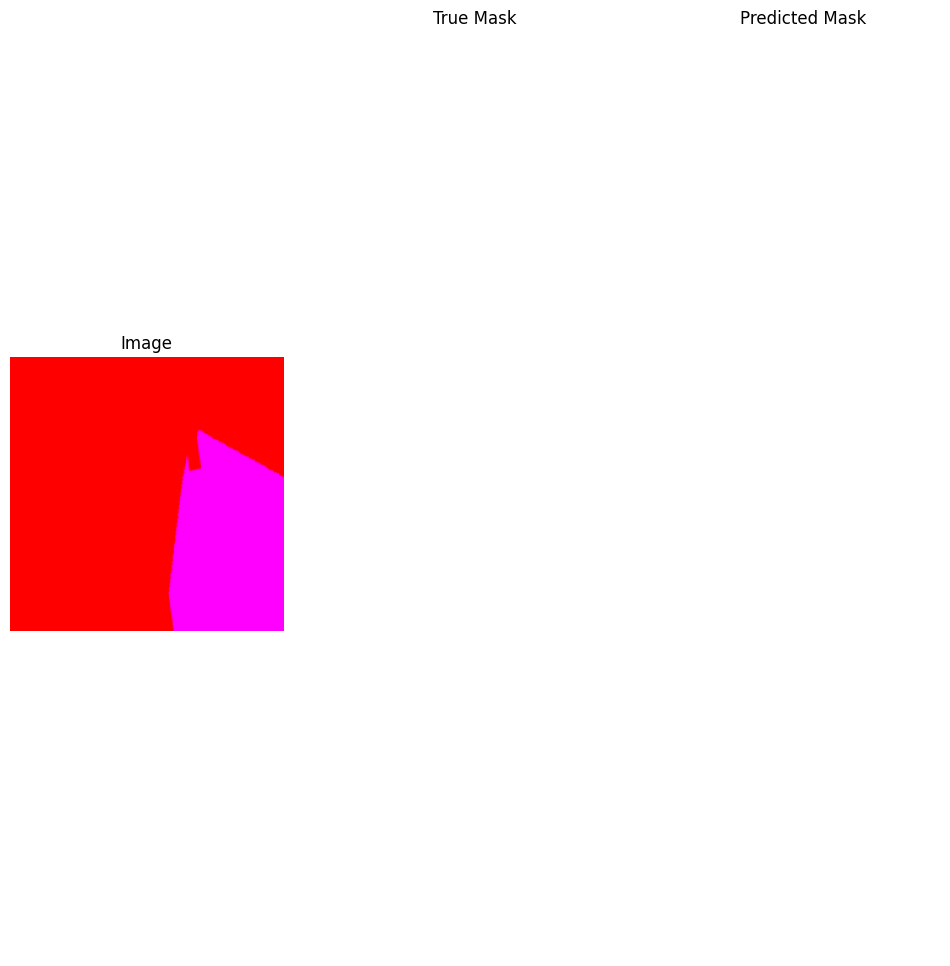

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step


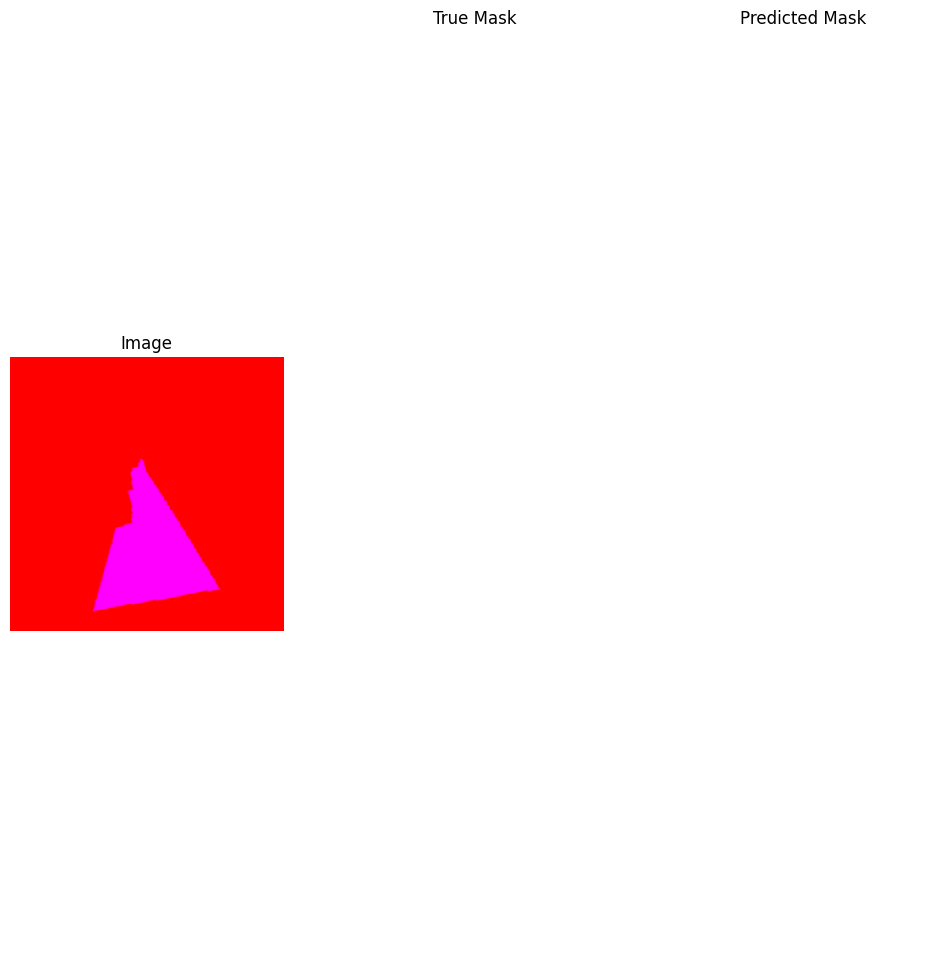

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step


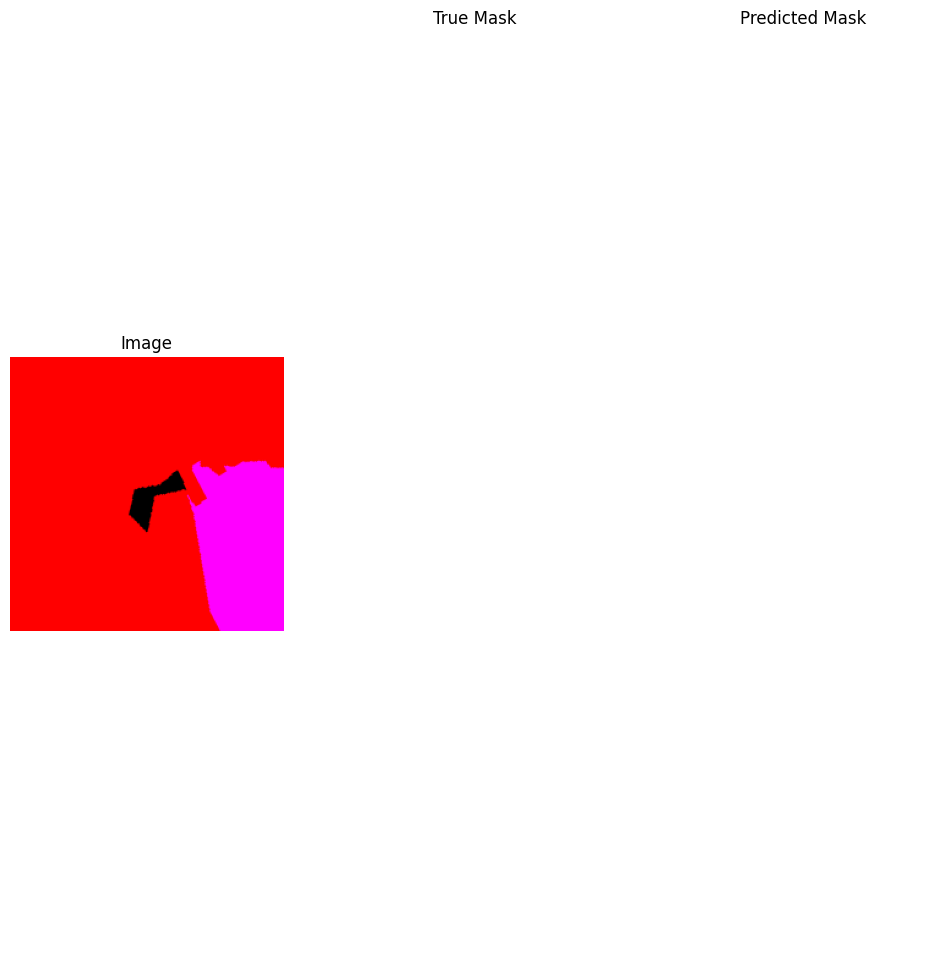

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


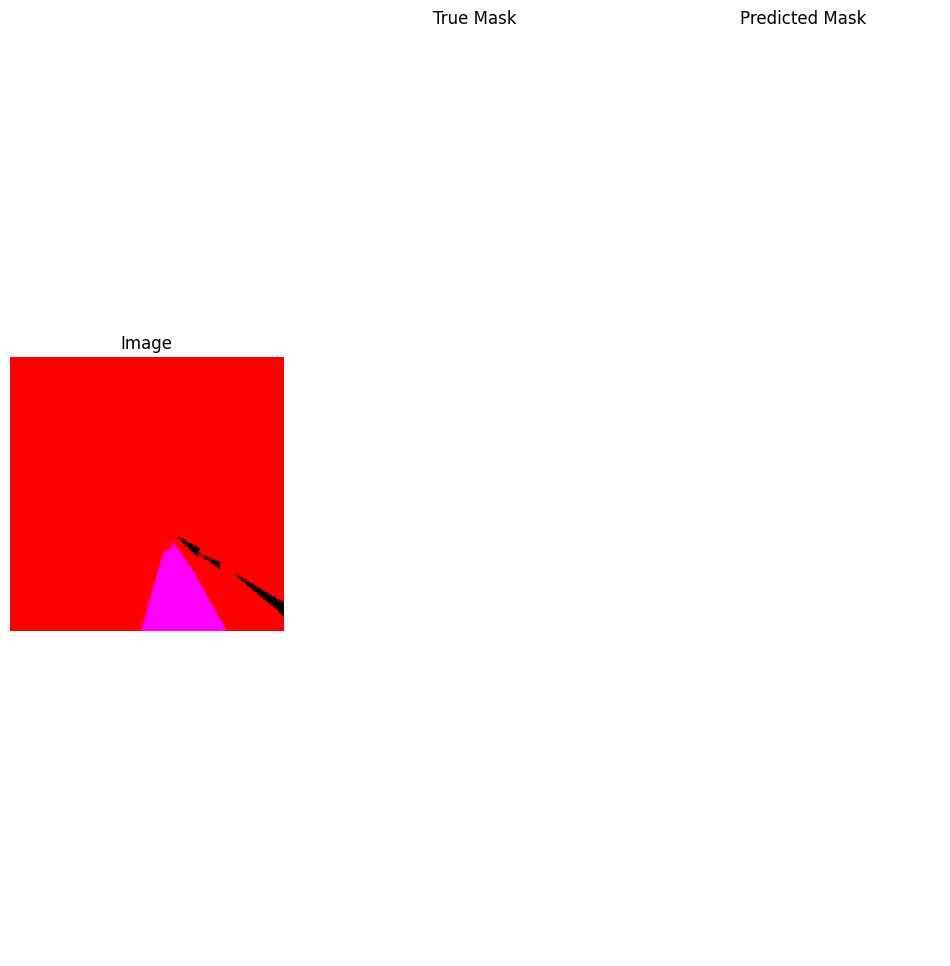

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


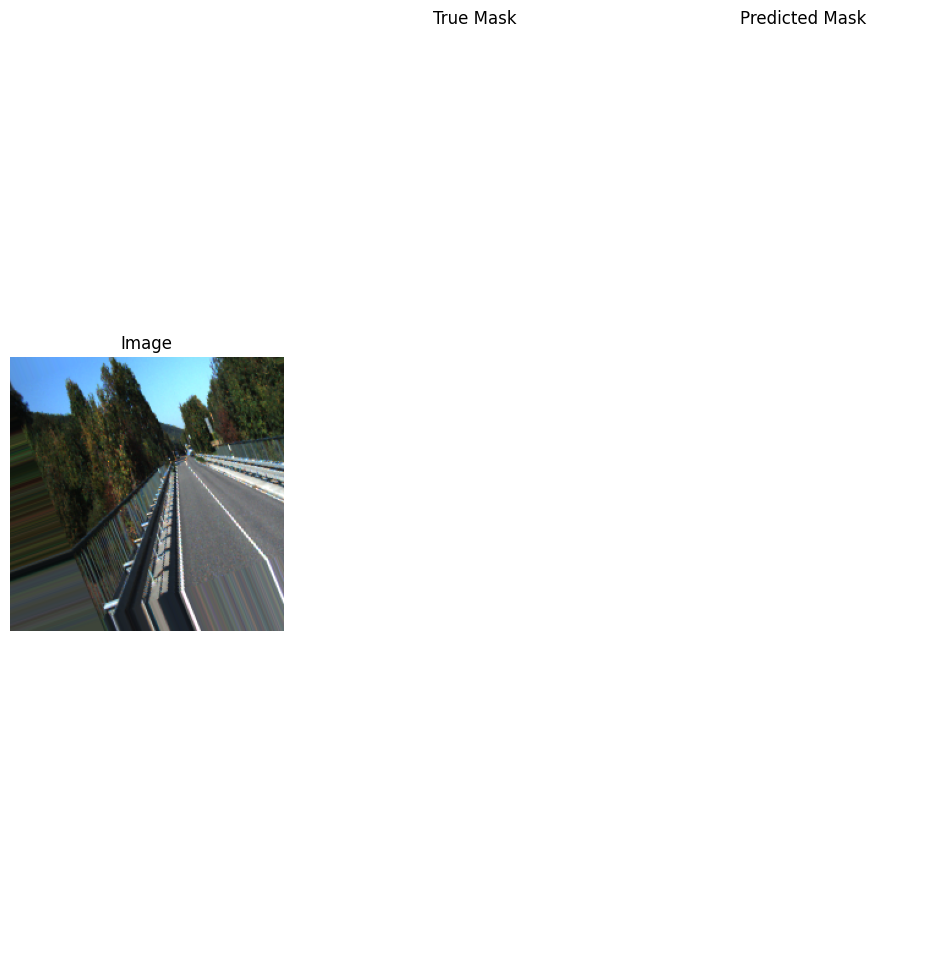

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step


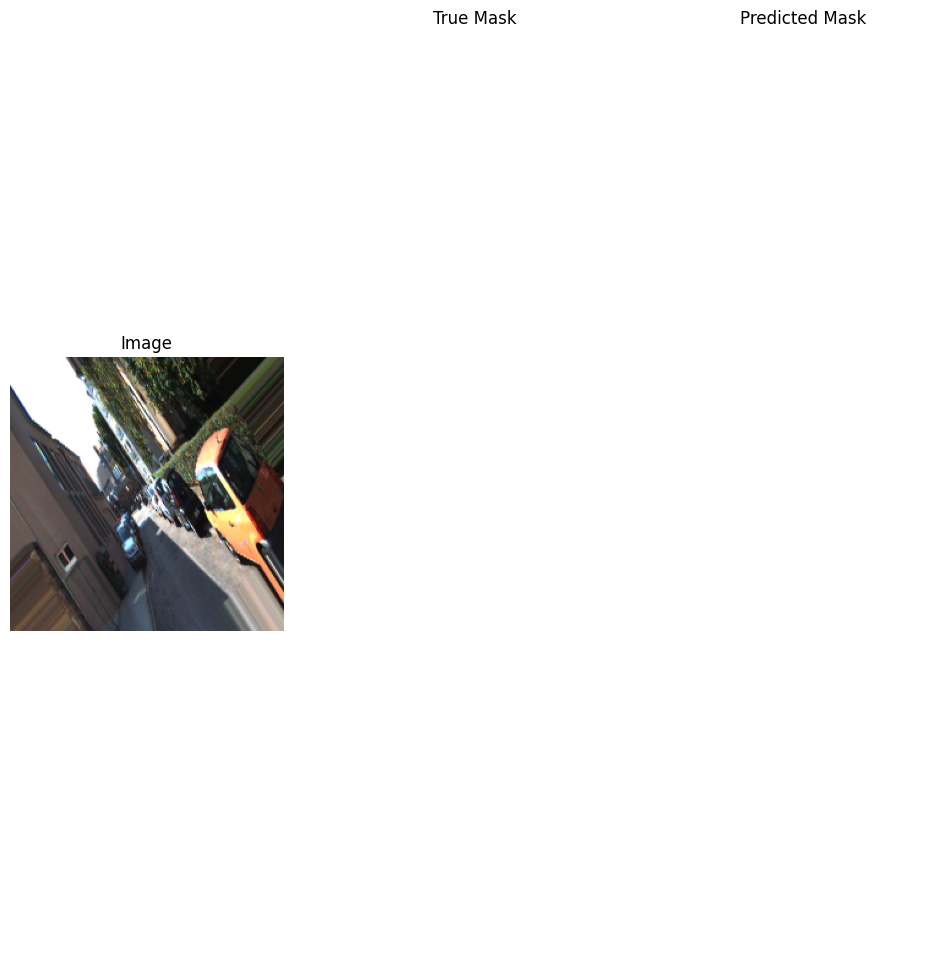

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


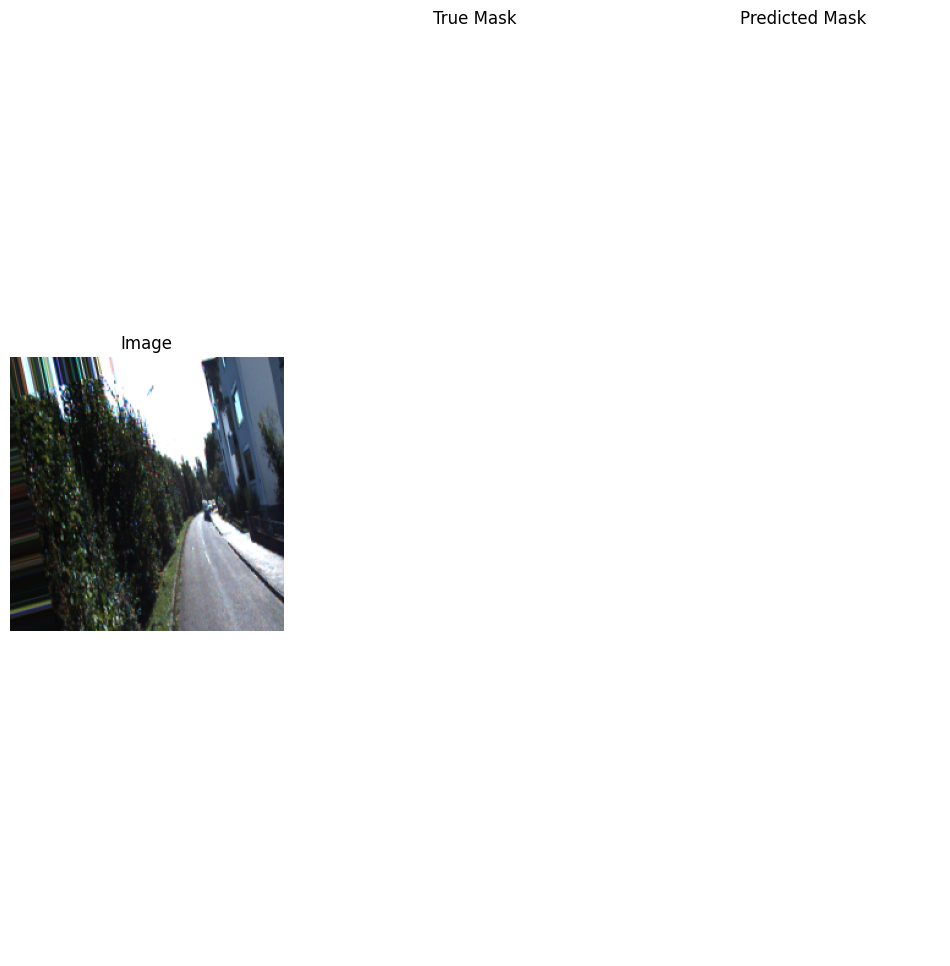

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


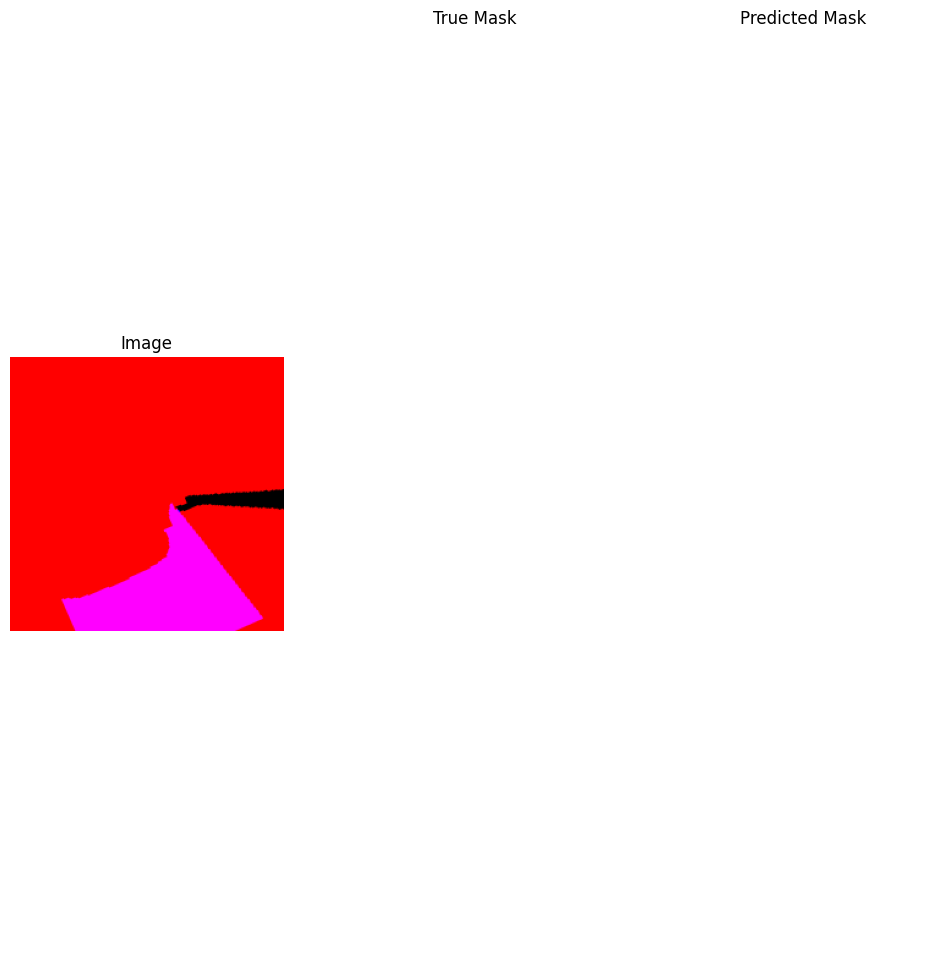

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step


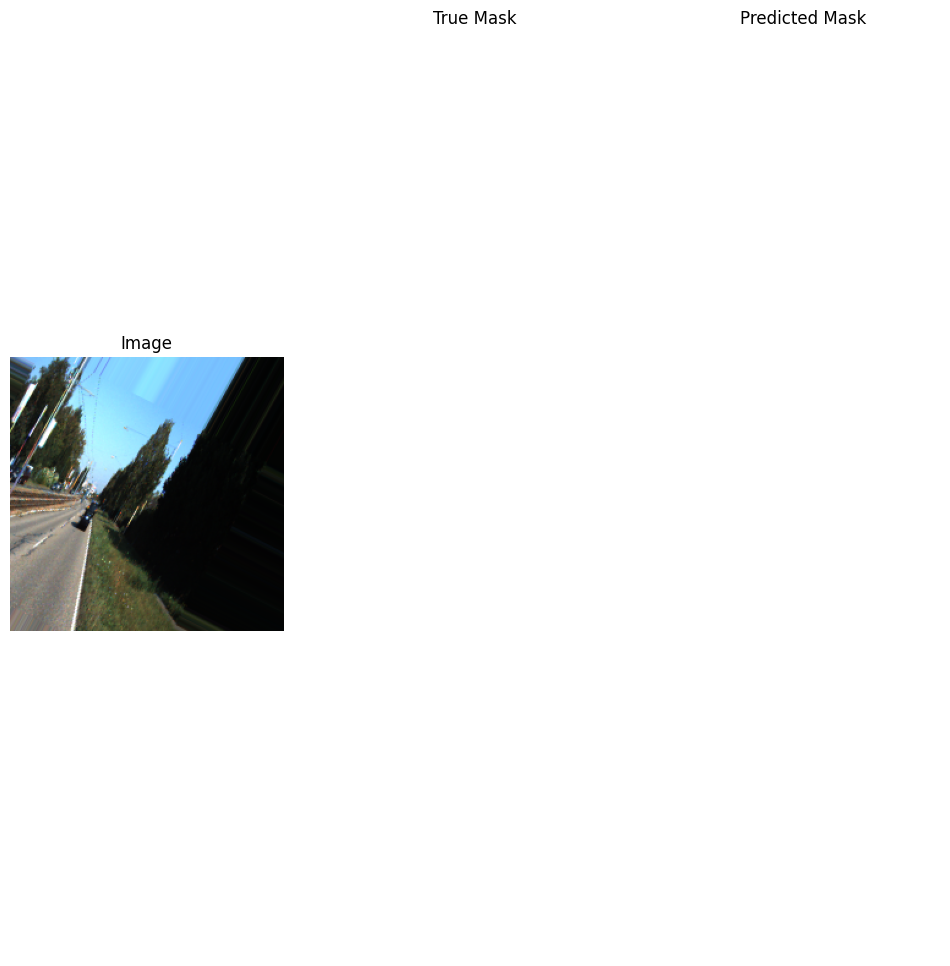

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step


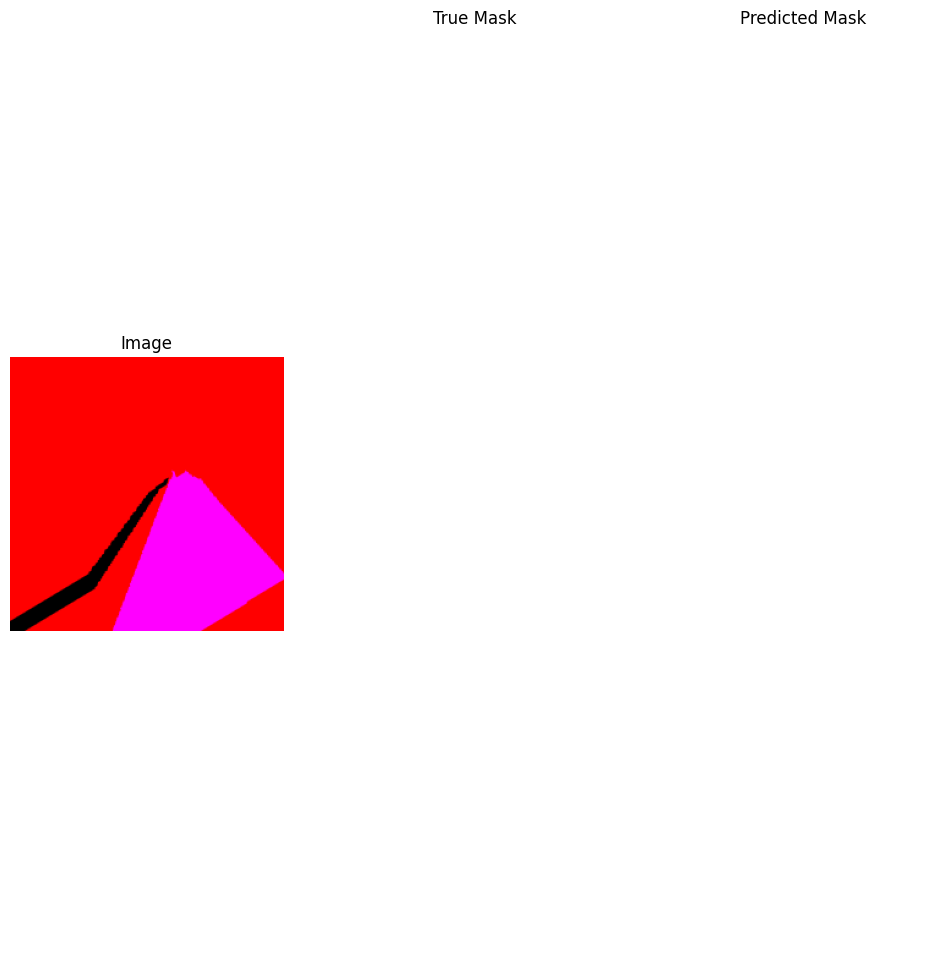

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


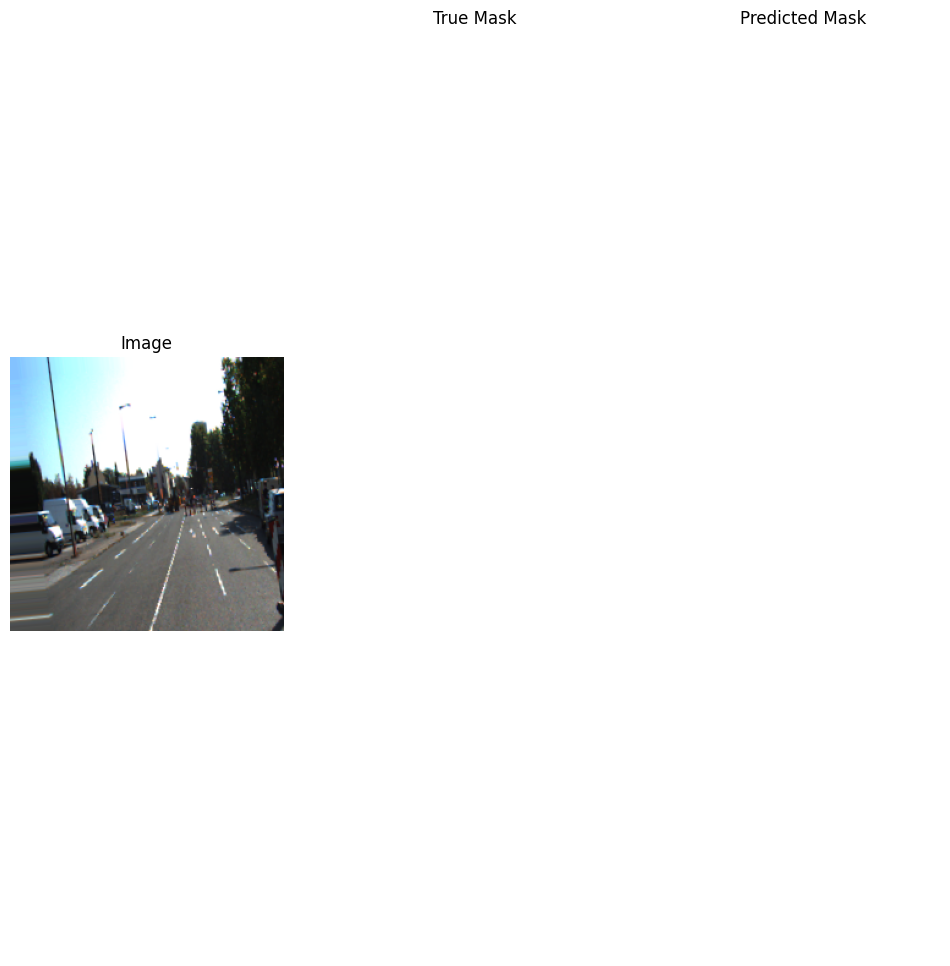

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step


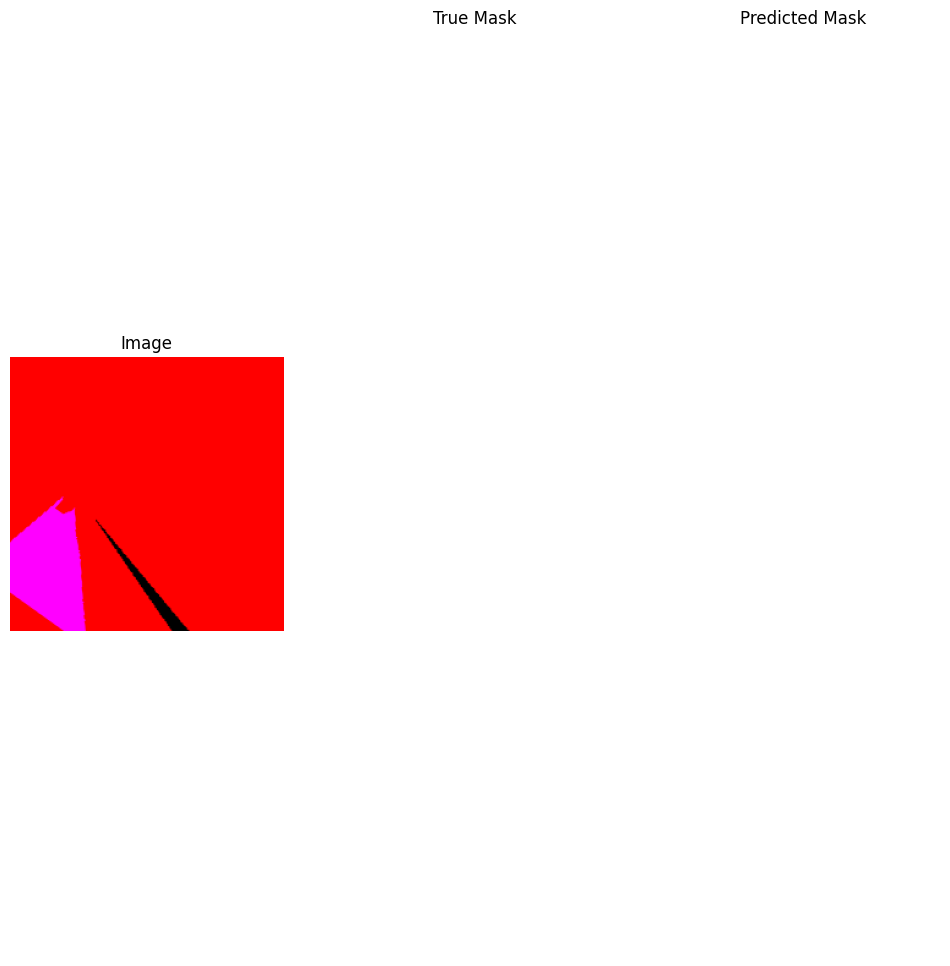

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


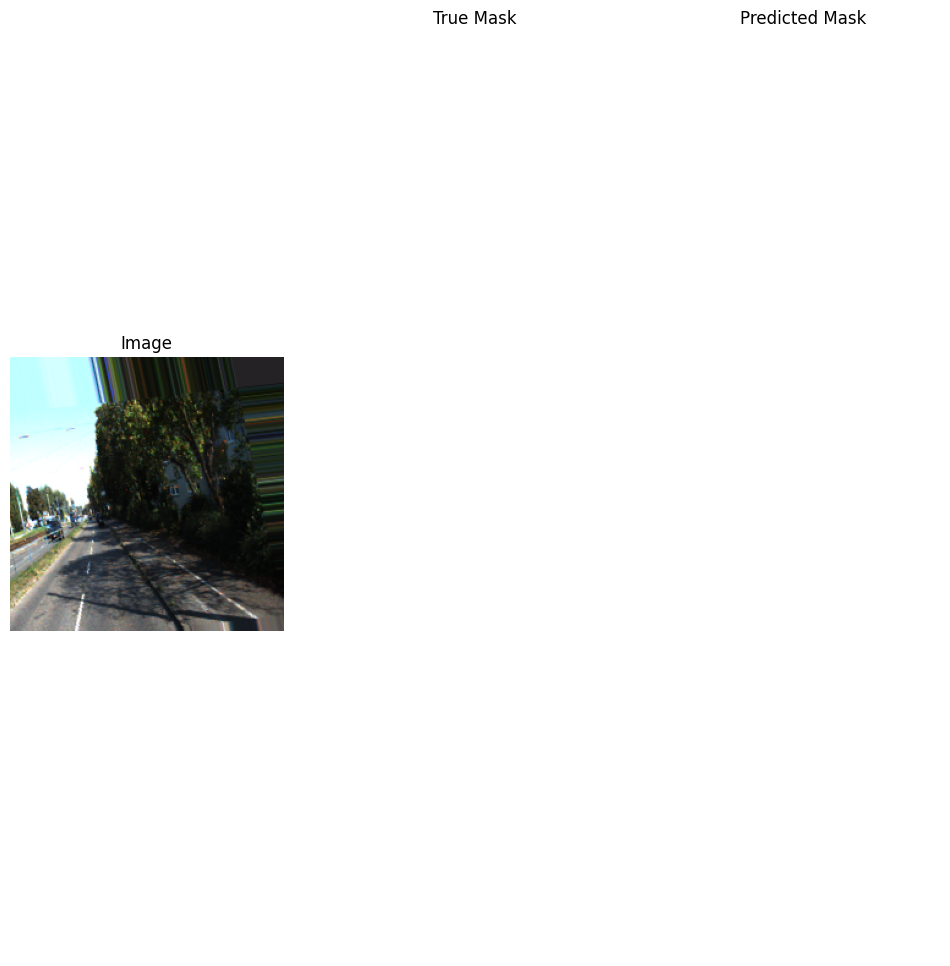

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step


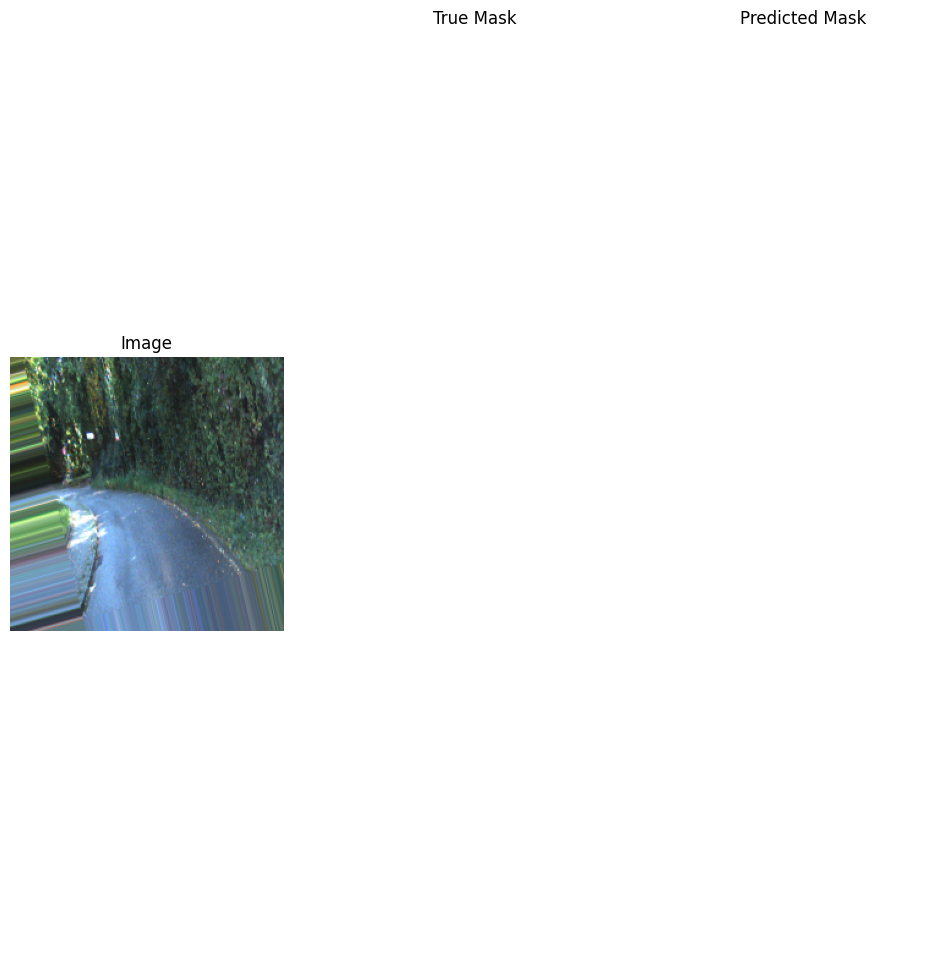

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step


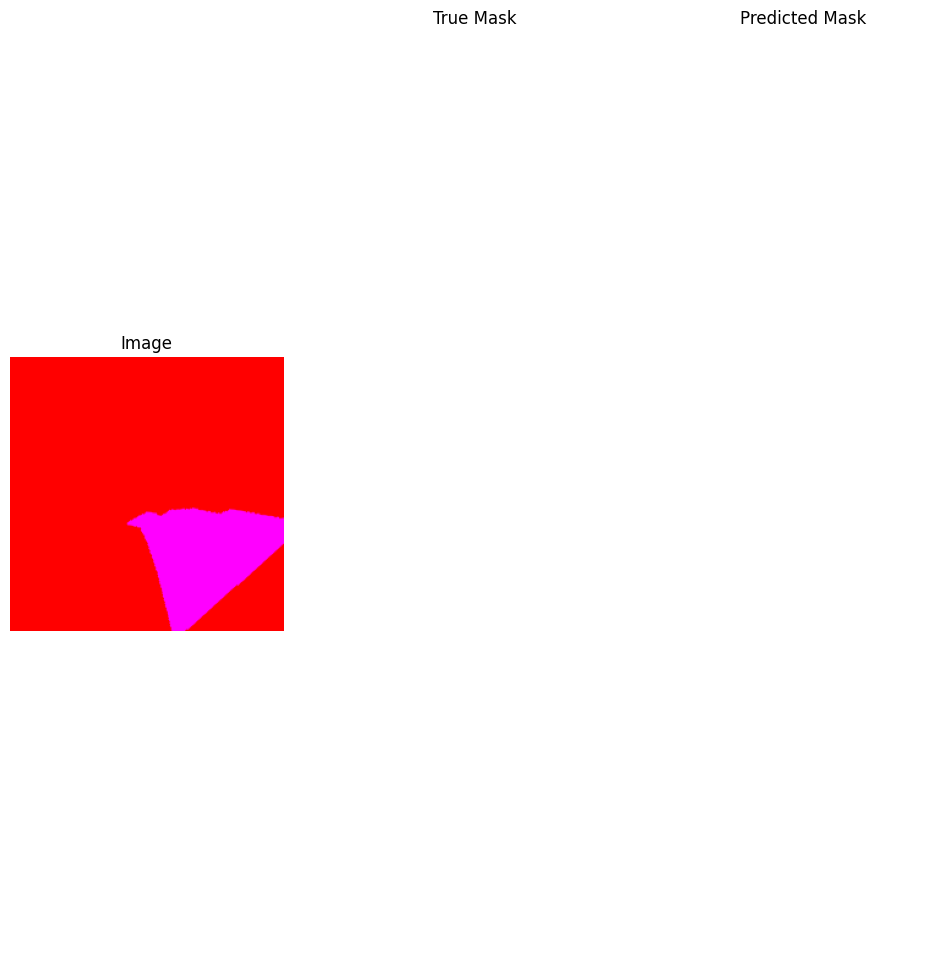

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


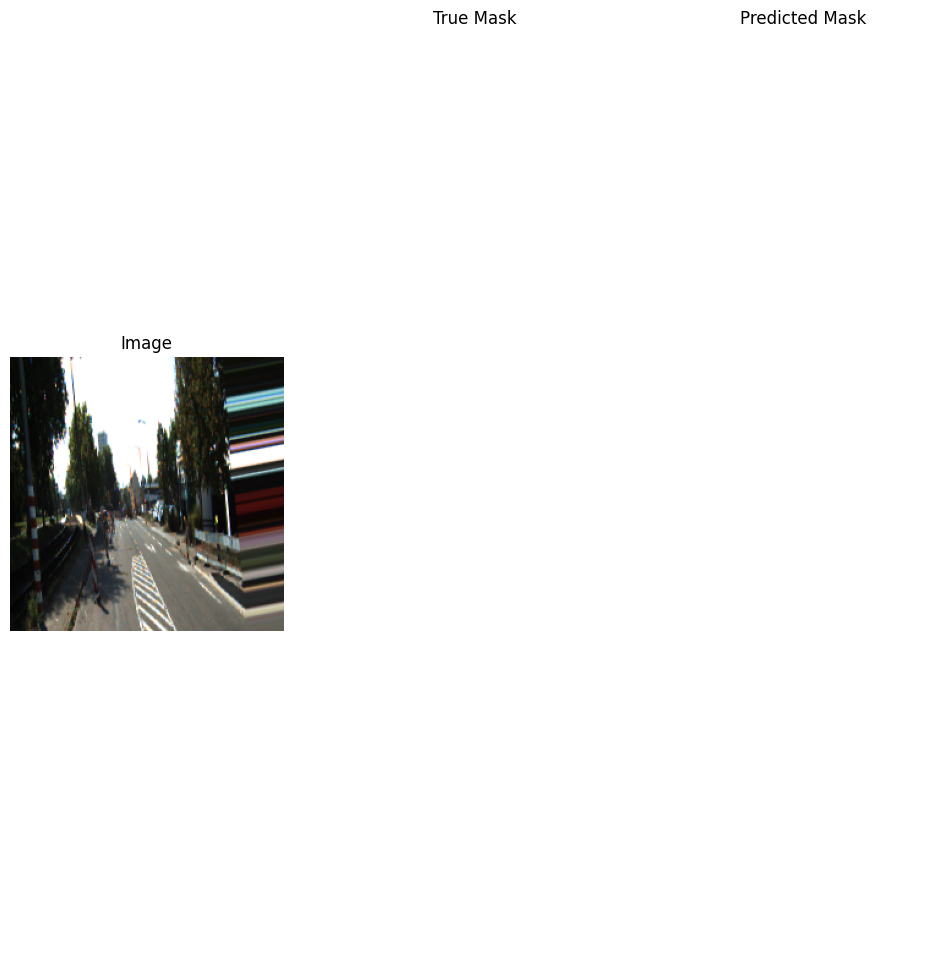

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


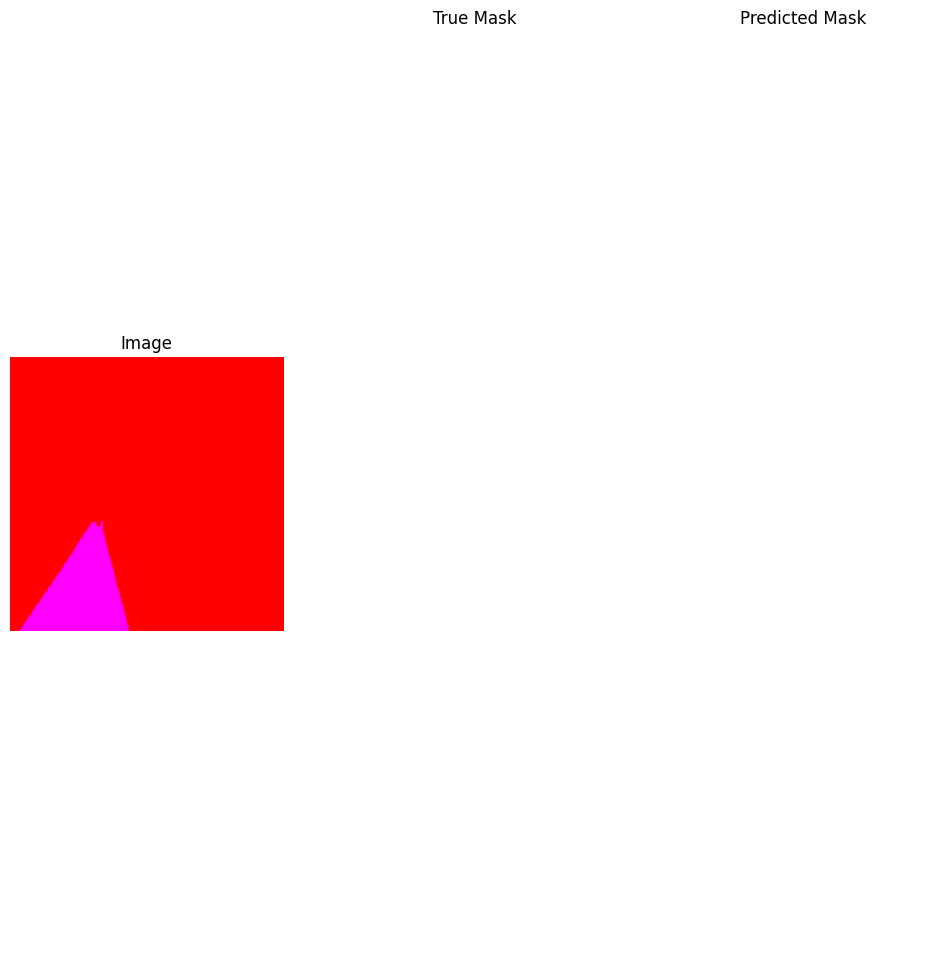

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


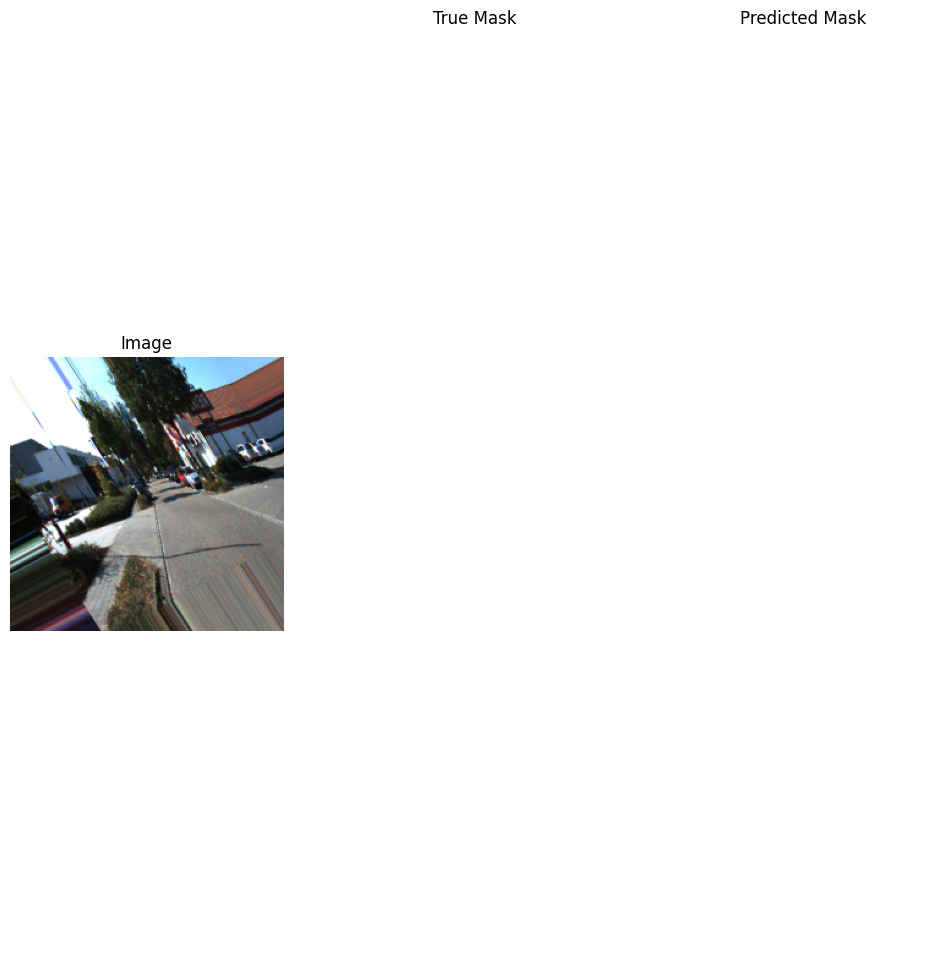

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


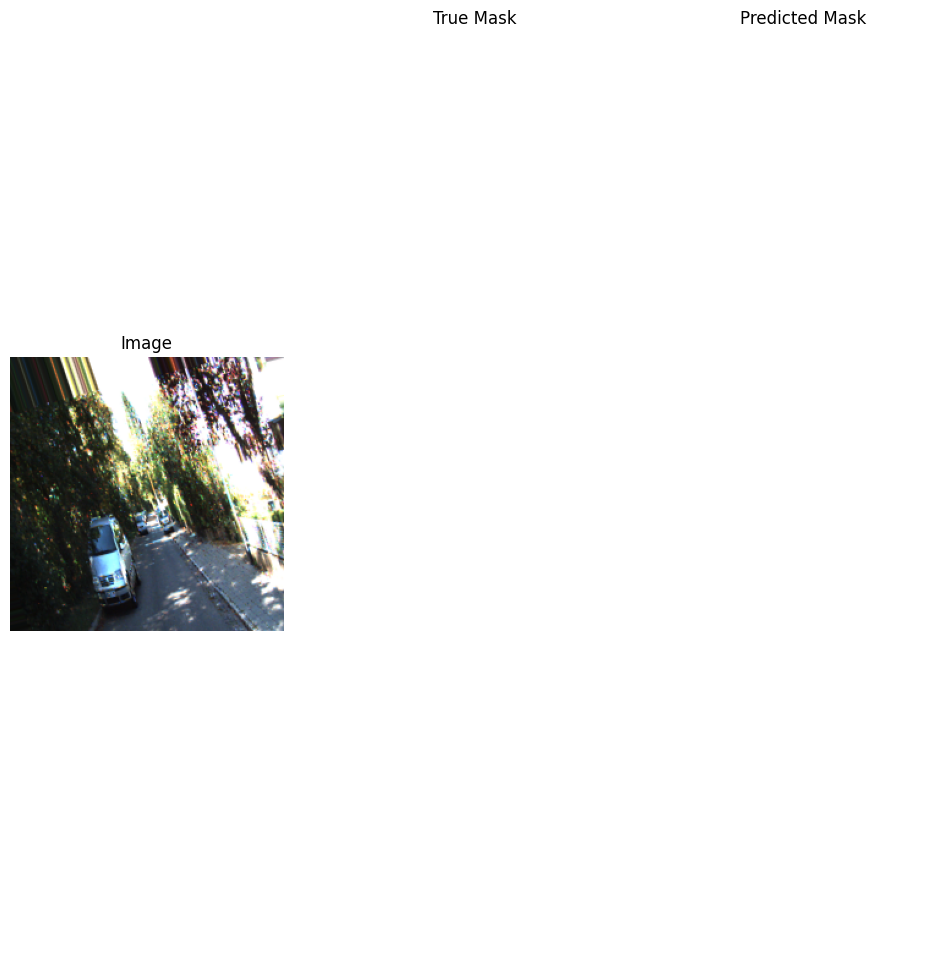

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


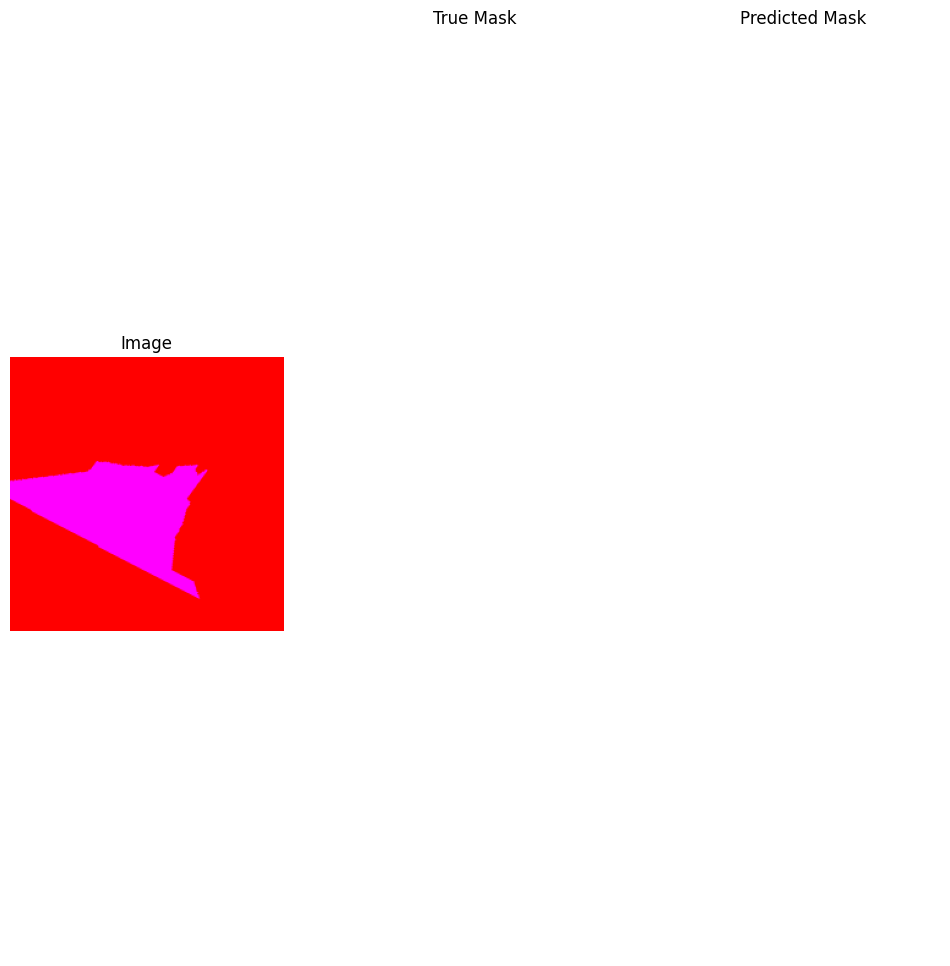

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step


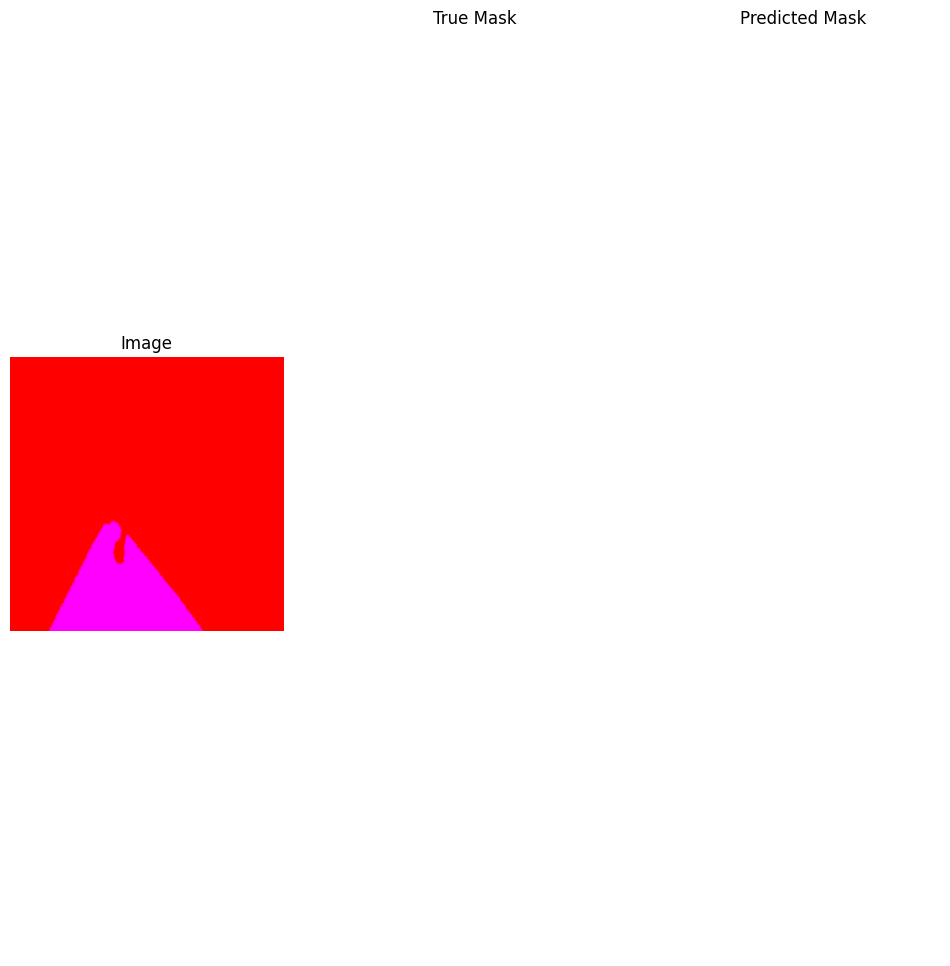

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step


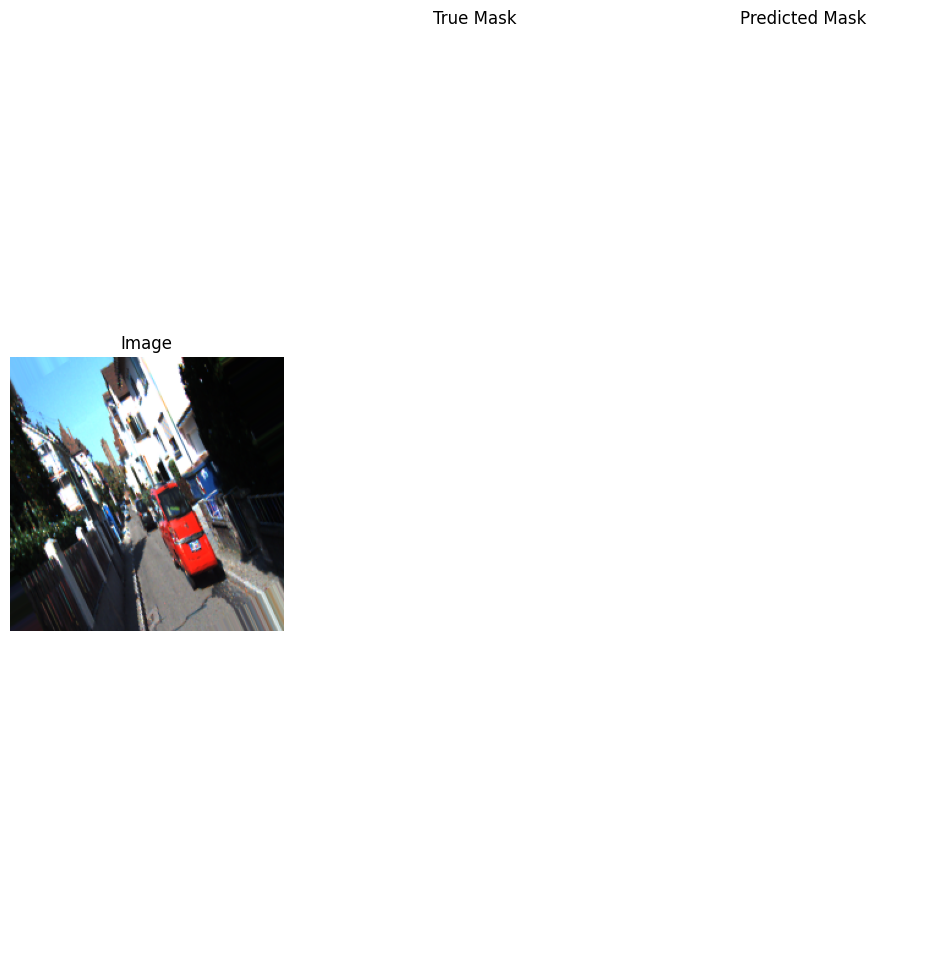

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


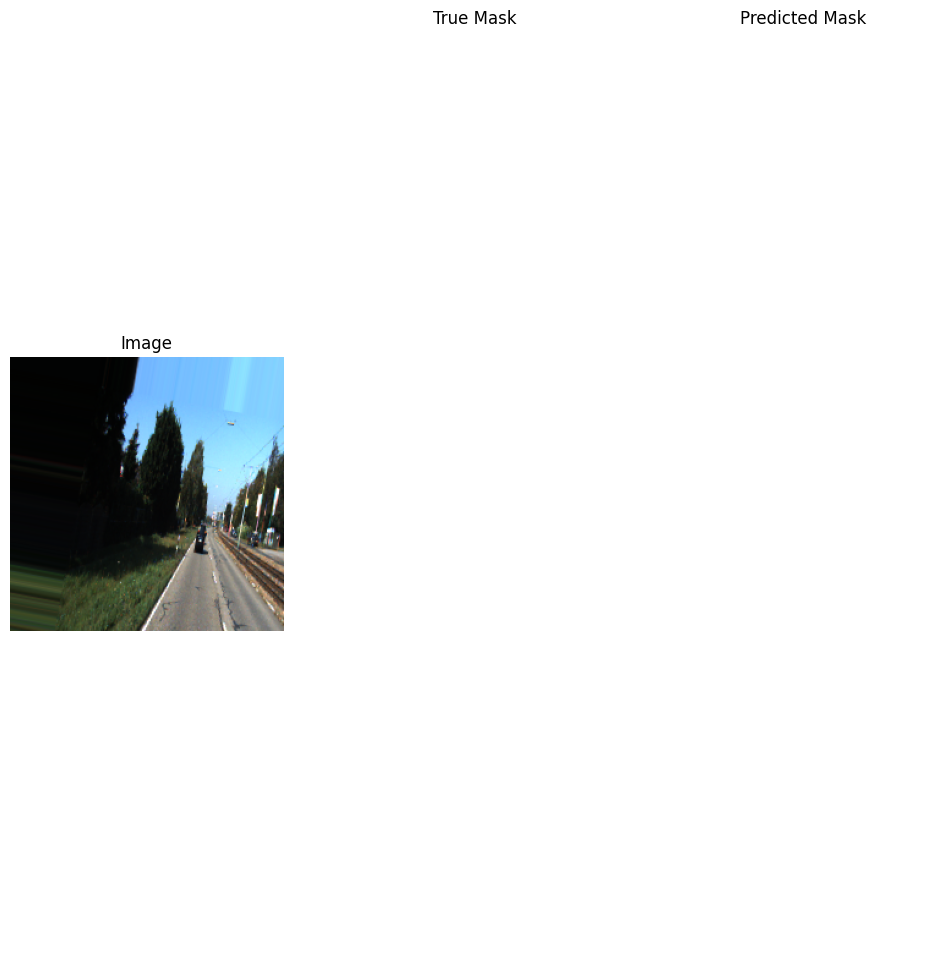

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step


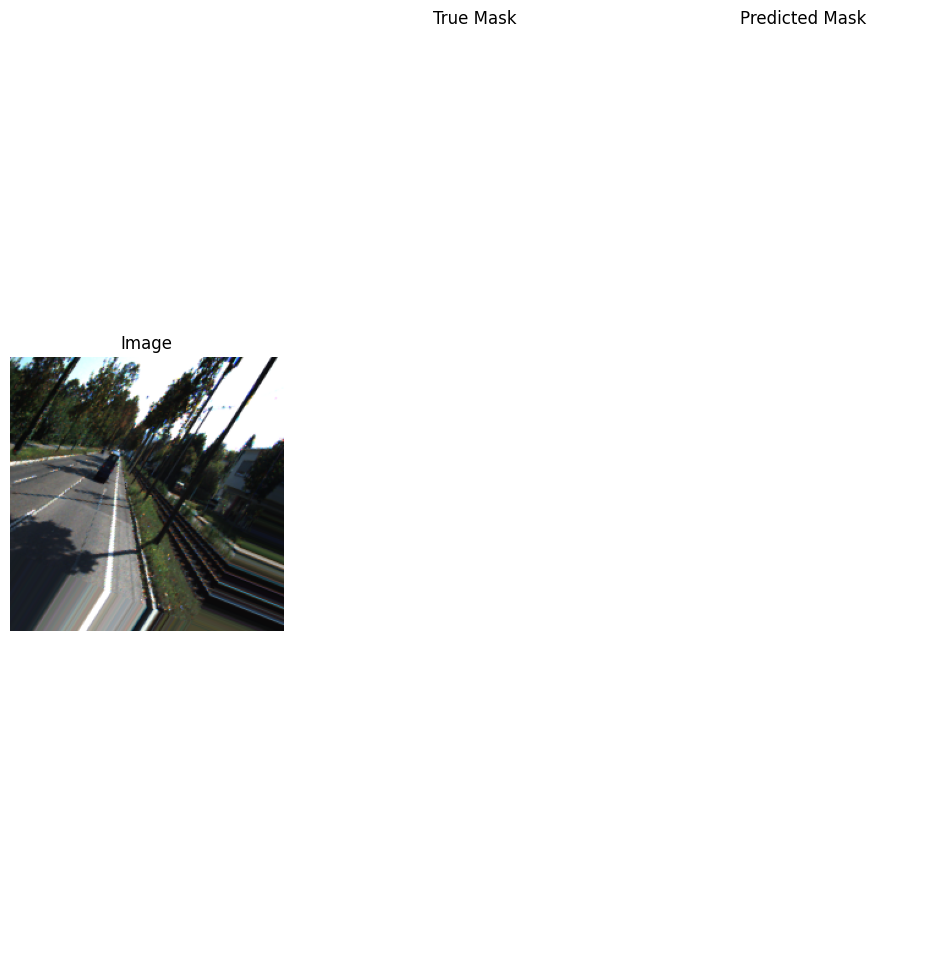

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step


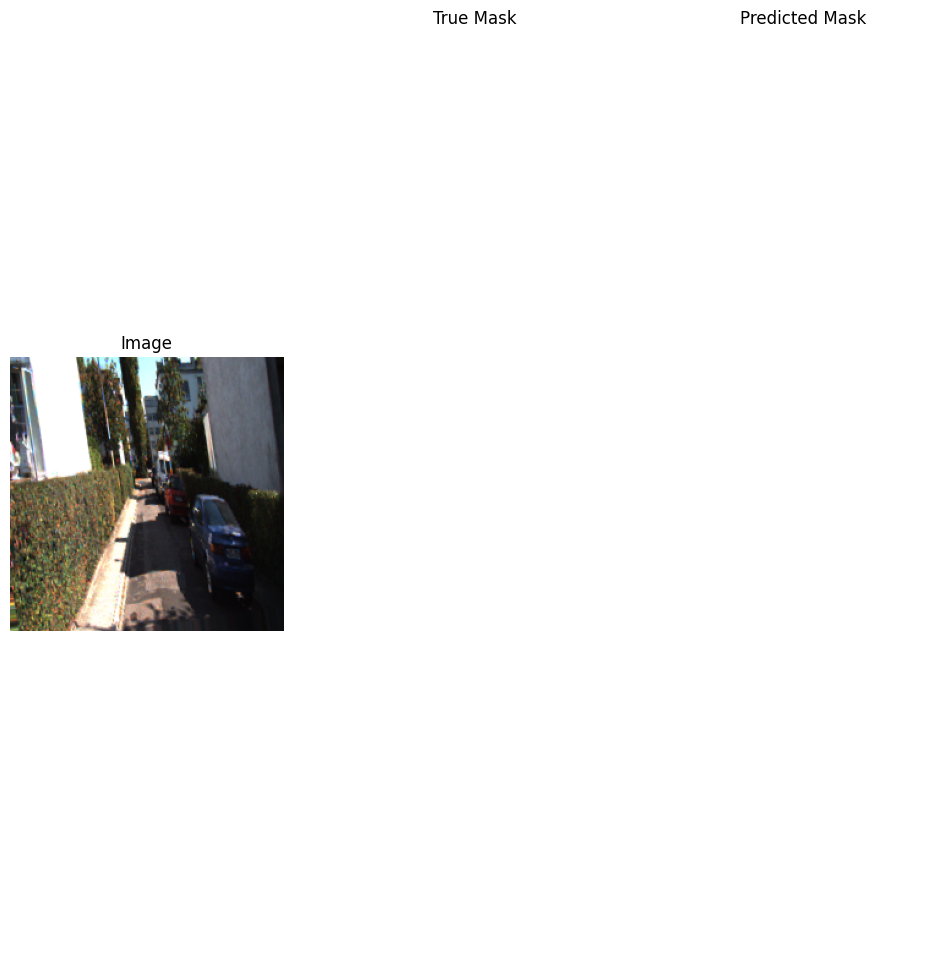

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


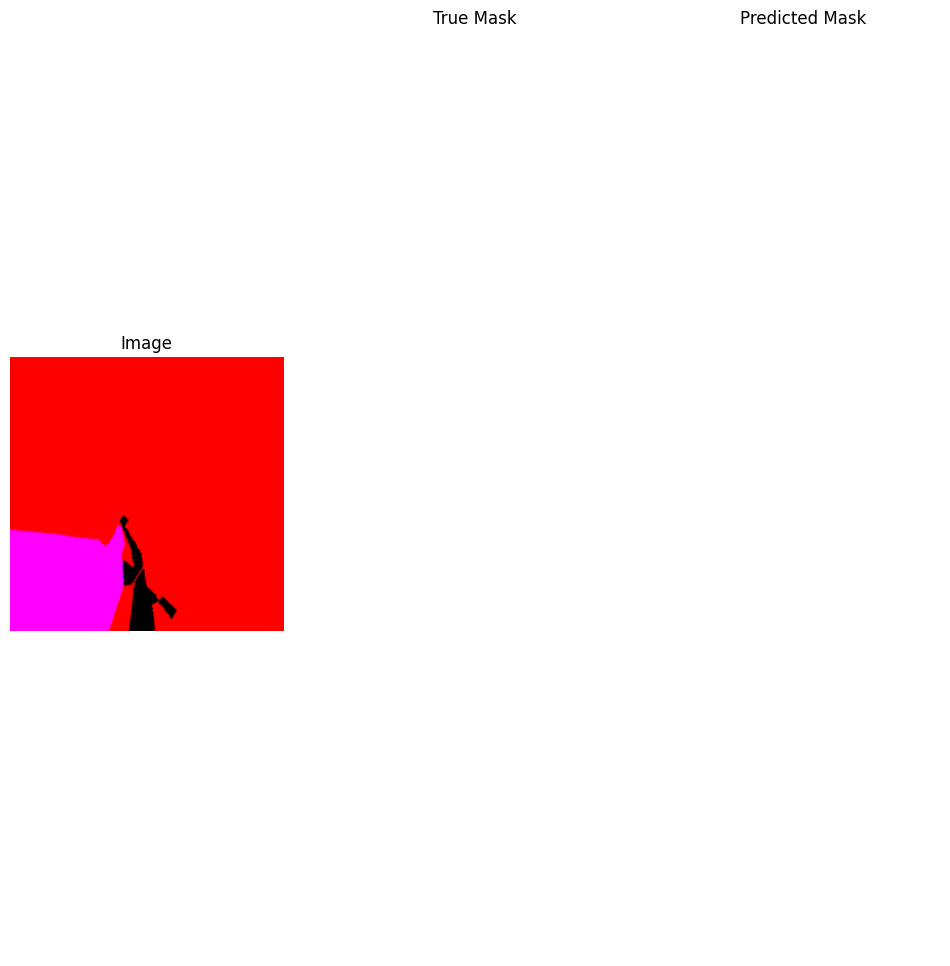

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


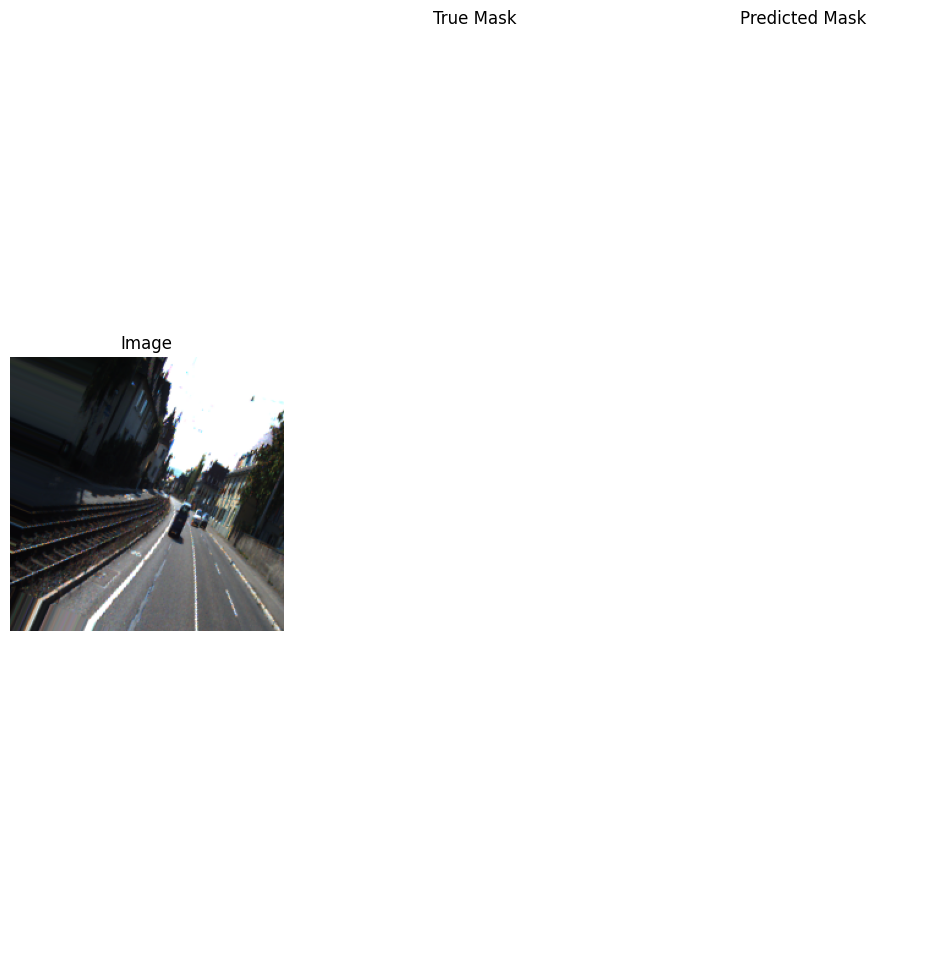

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


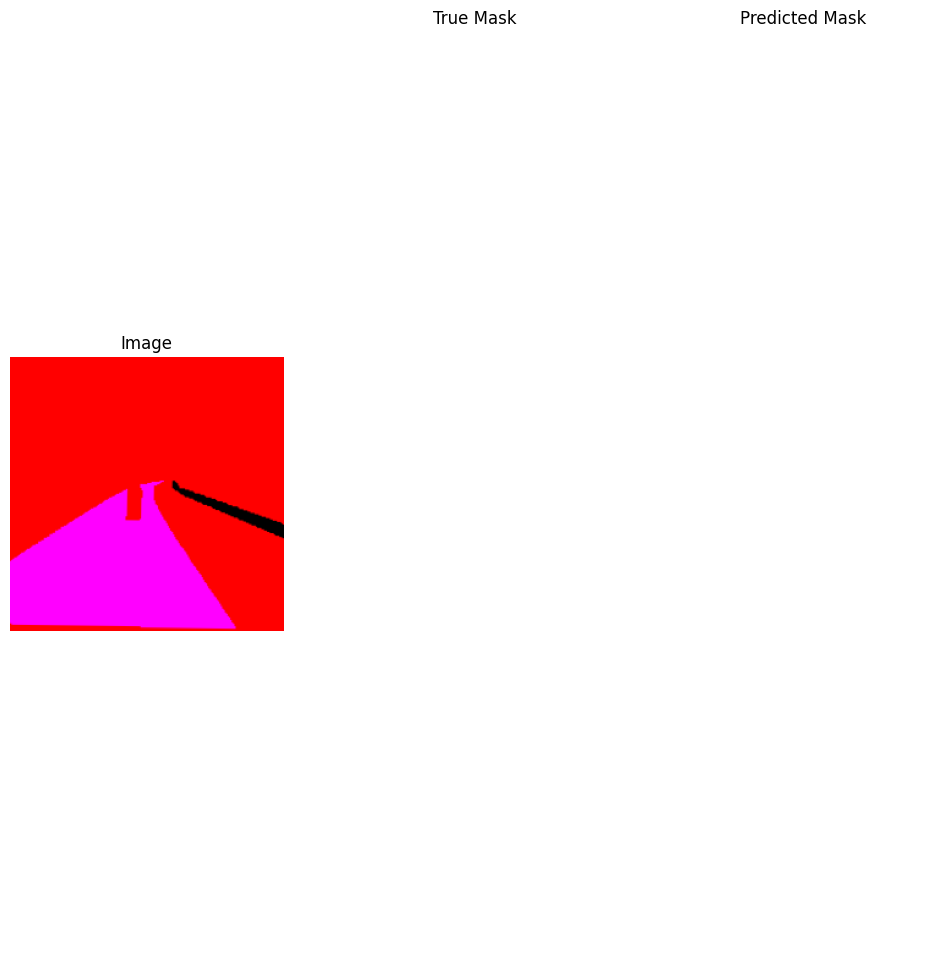

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step


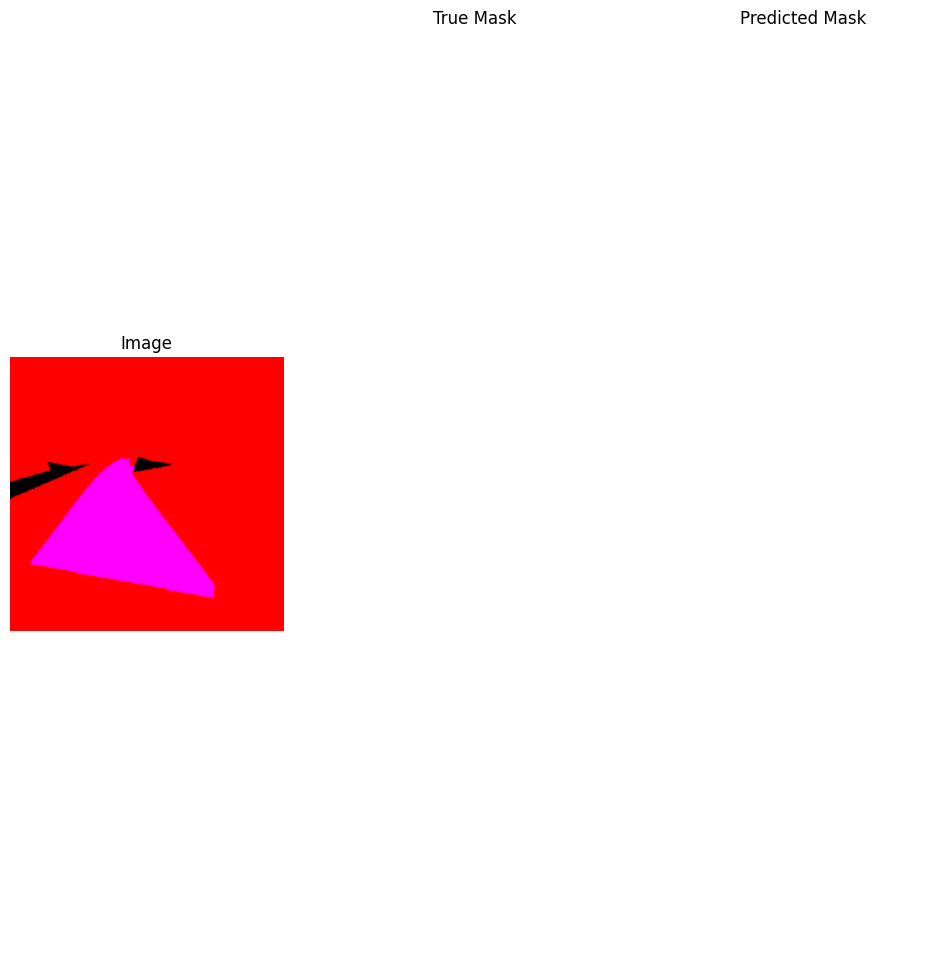

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


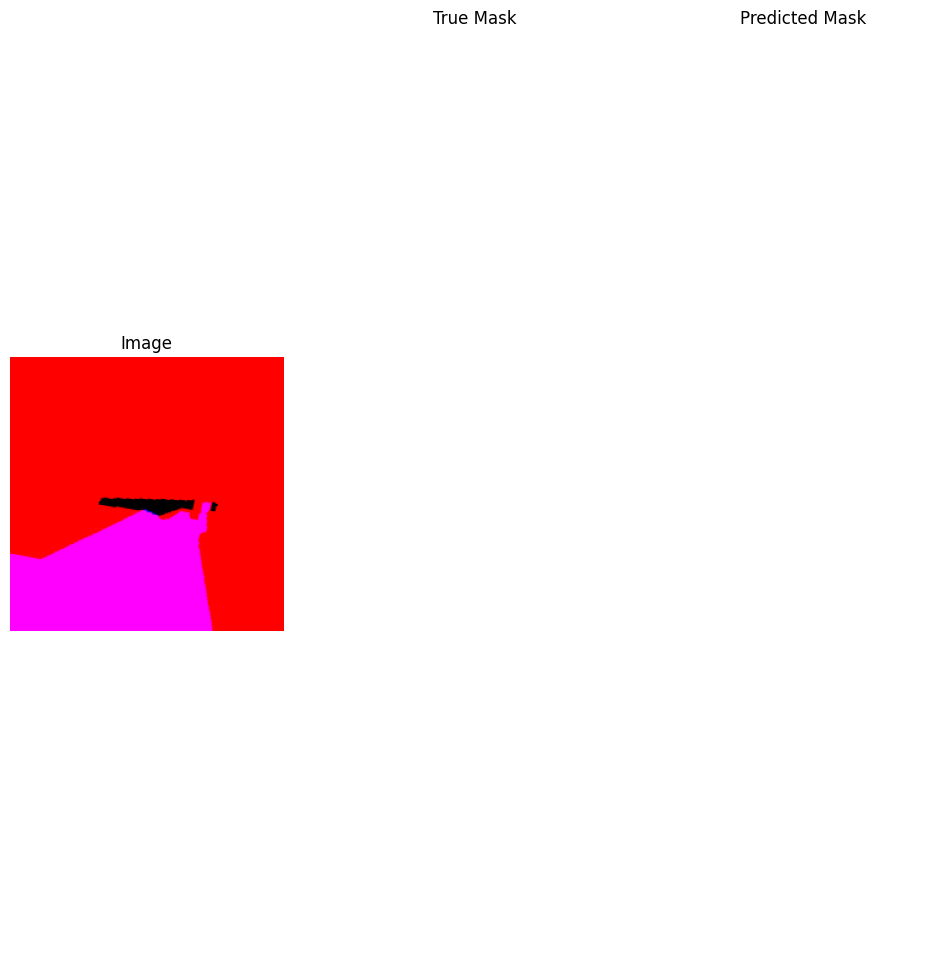

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step


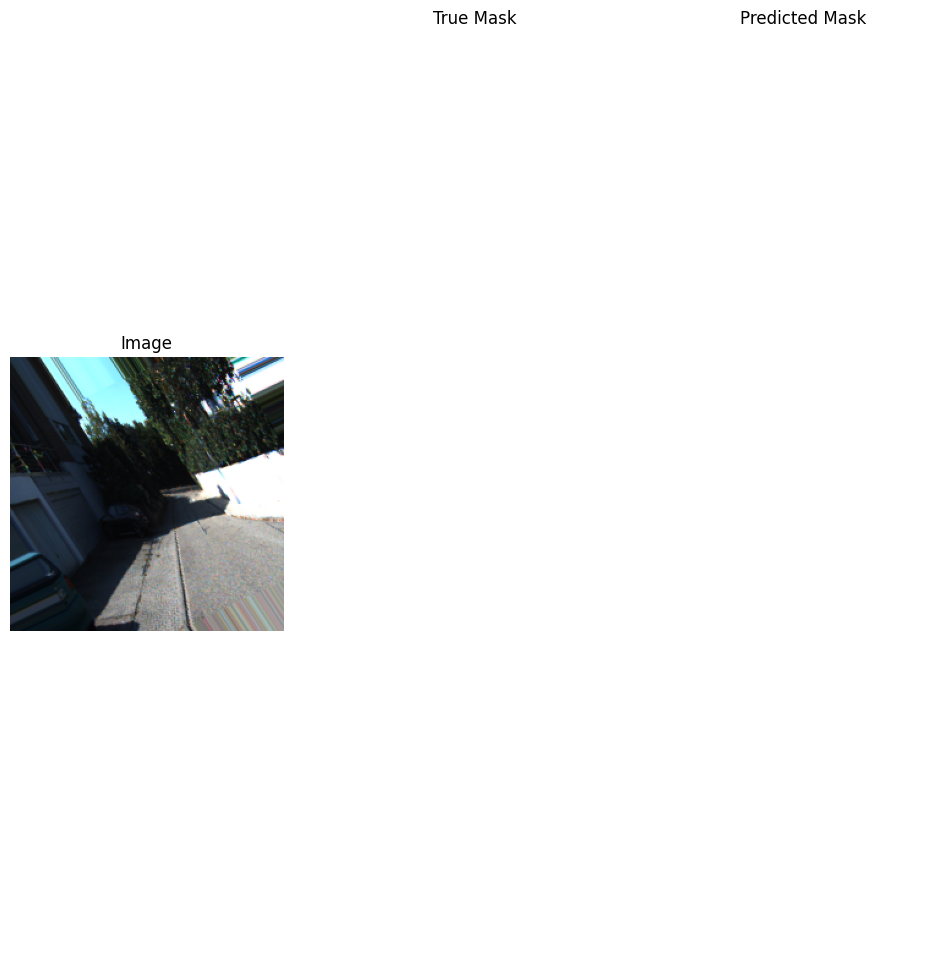

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


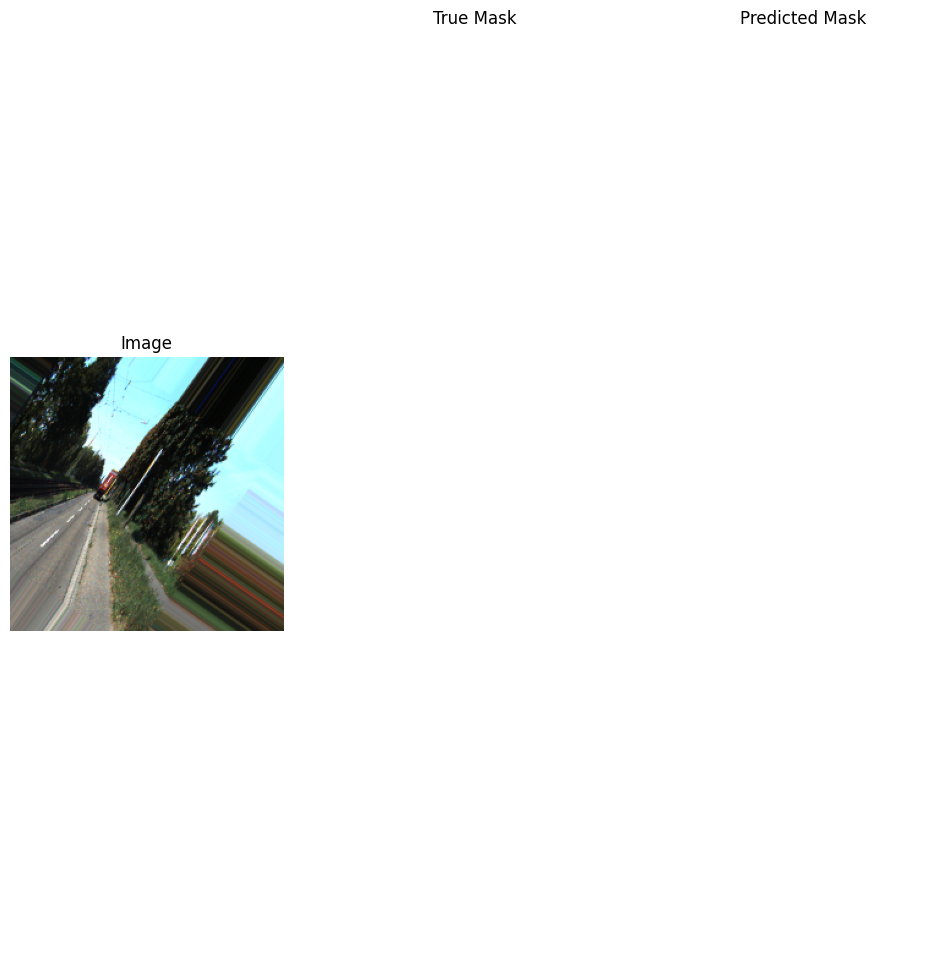

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


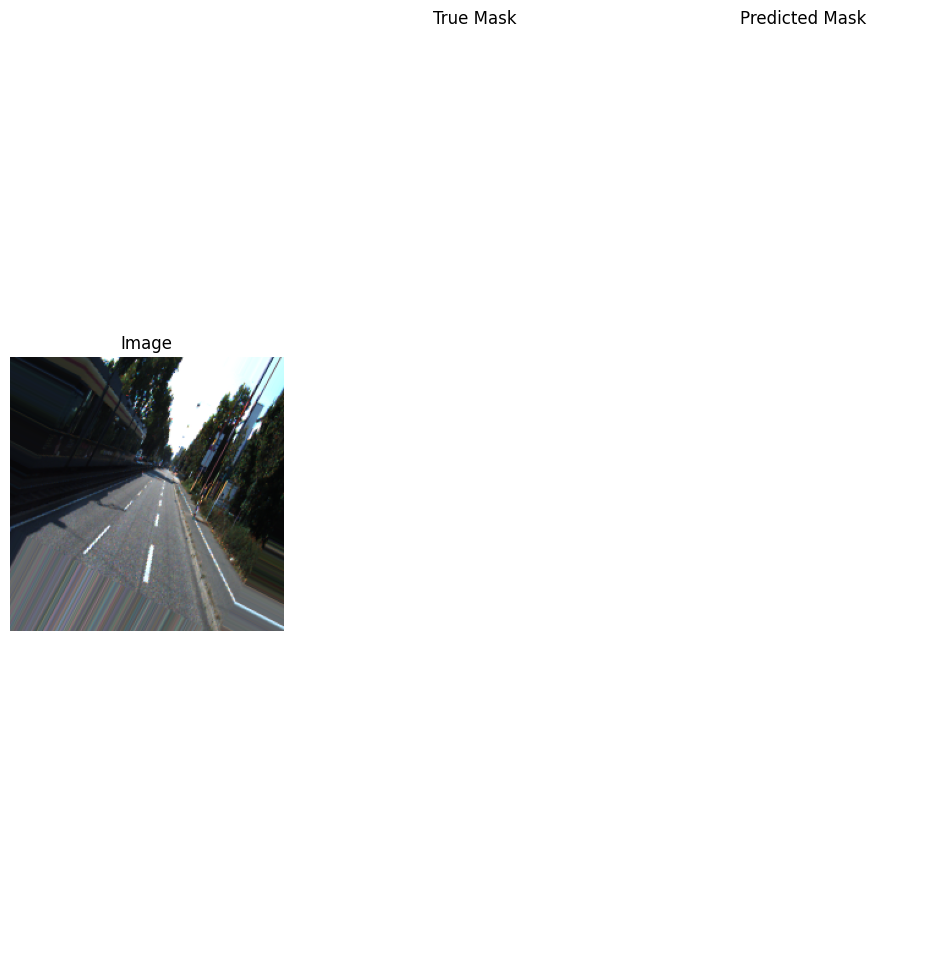

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step


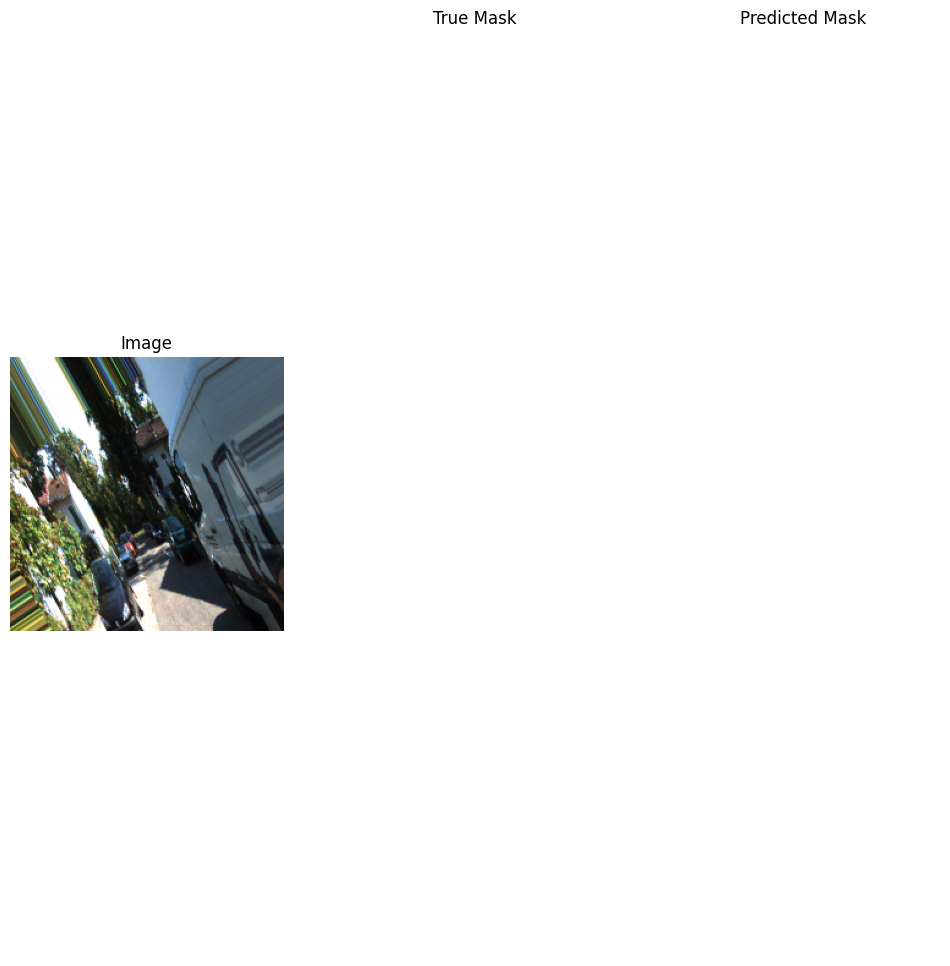

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


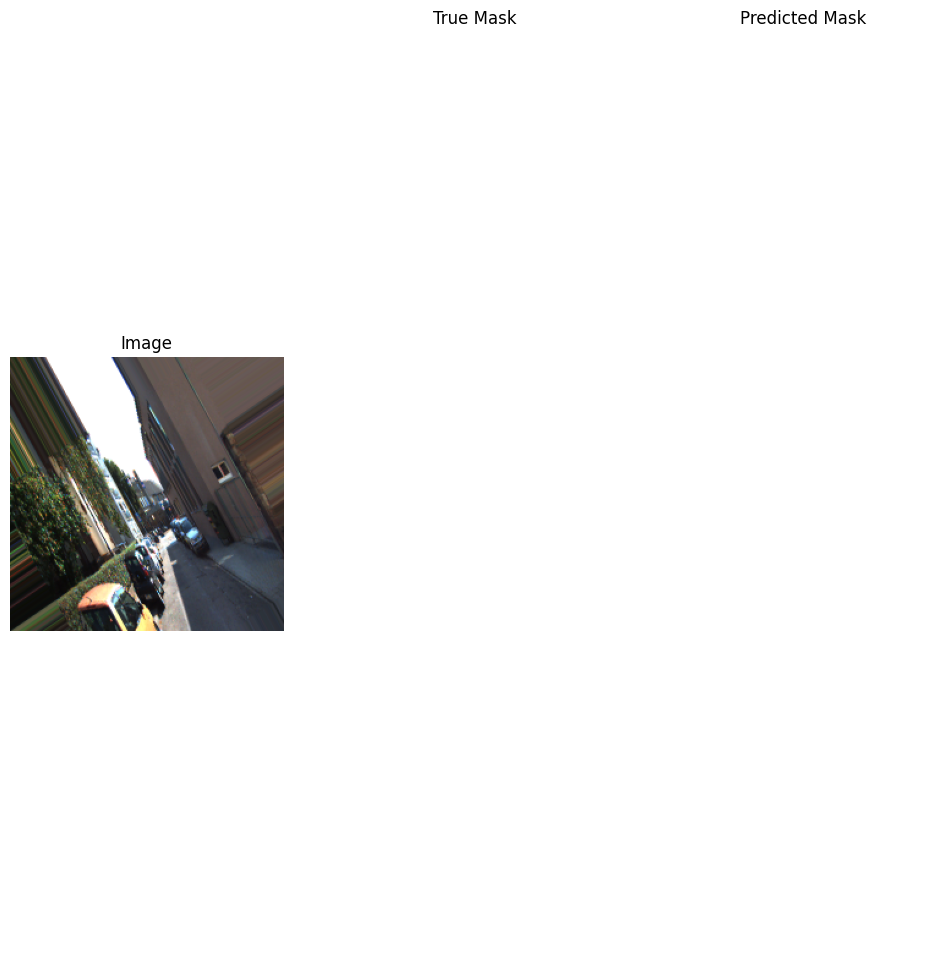

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


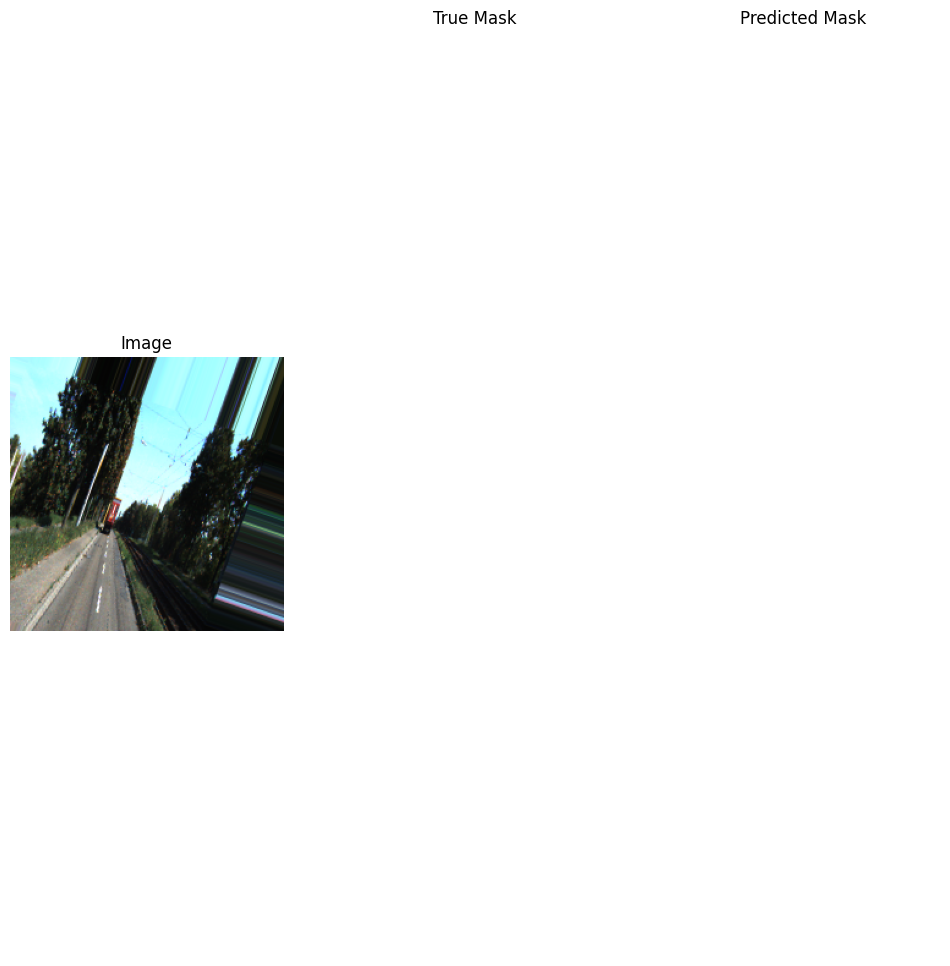

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step


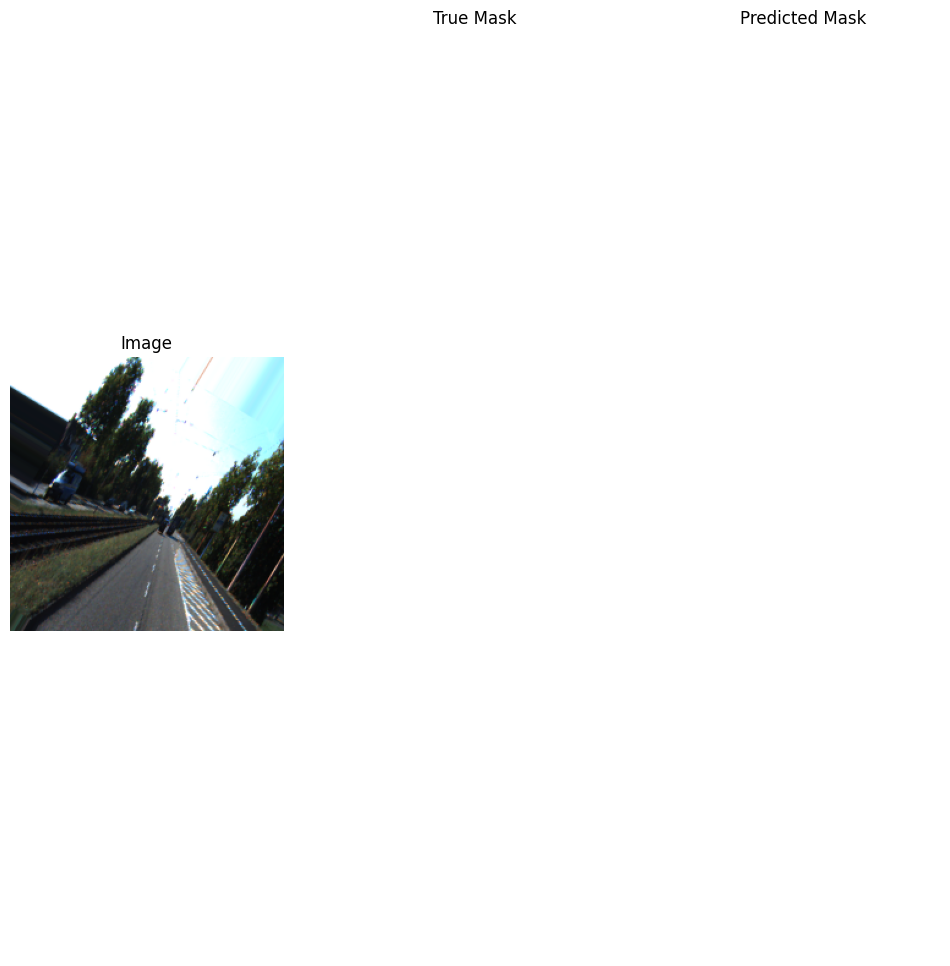

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


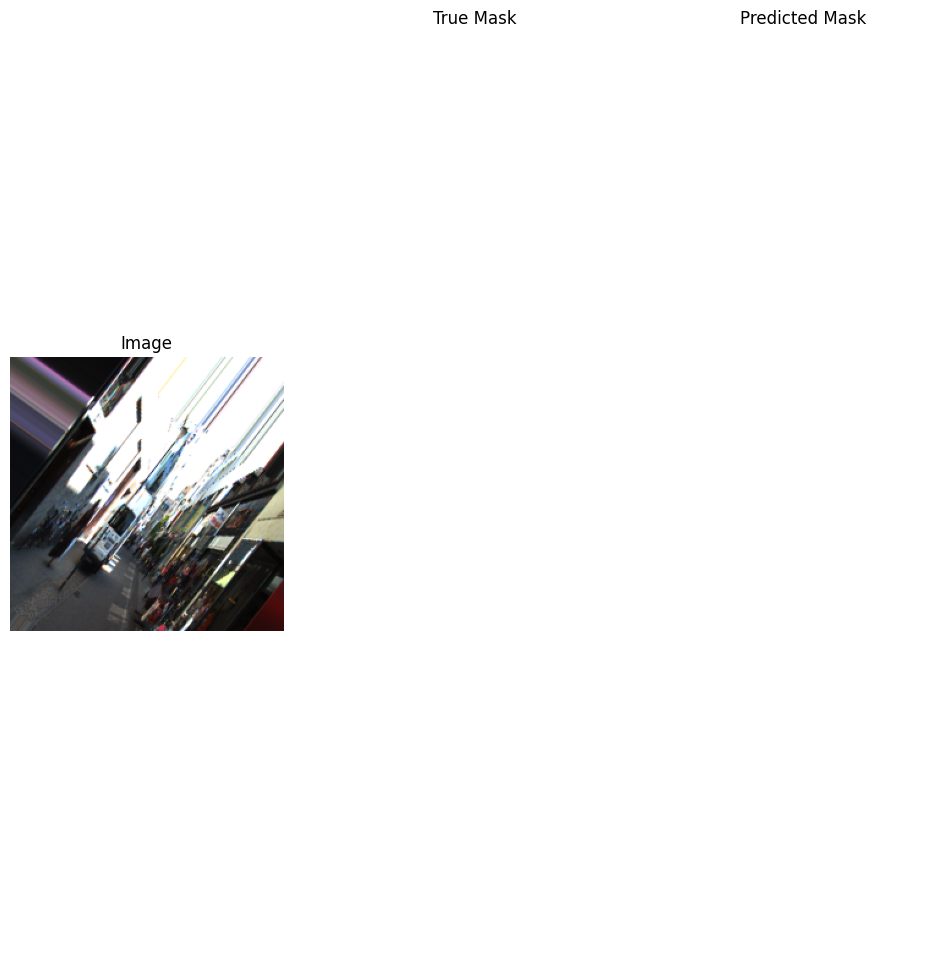

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


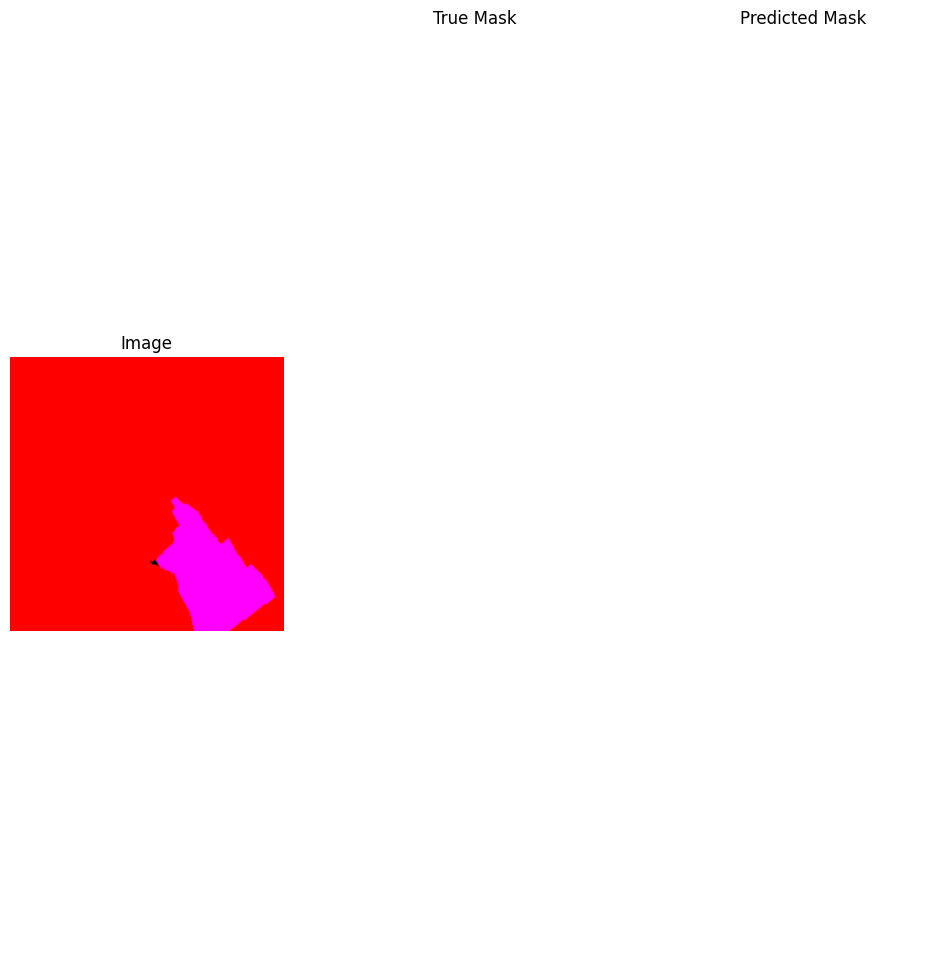

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


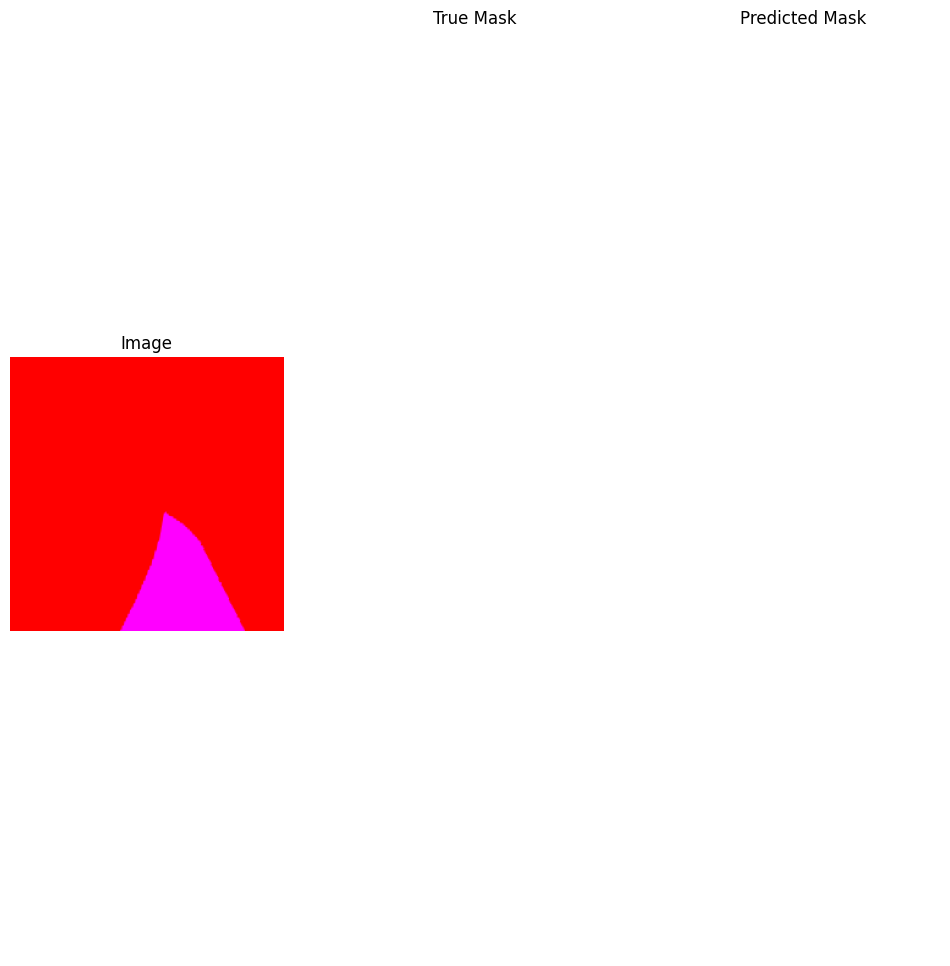

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step


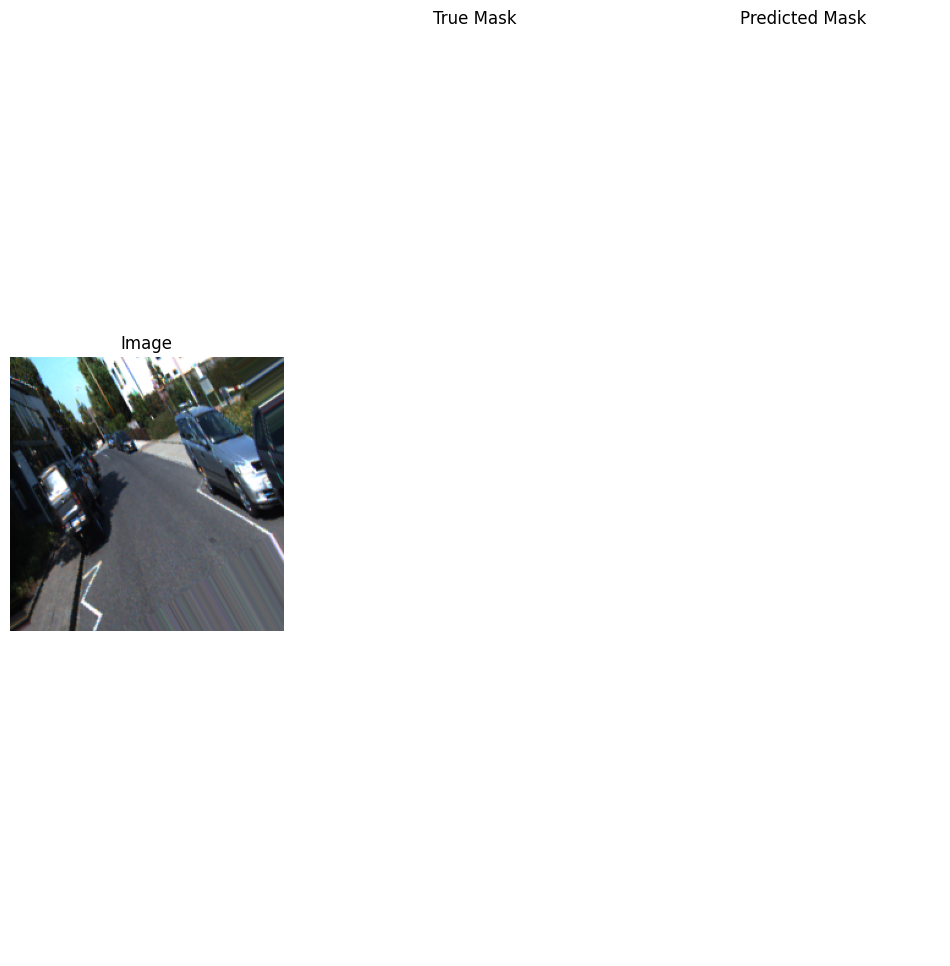

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


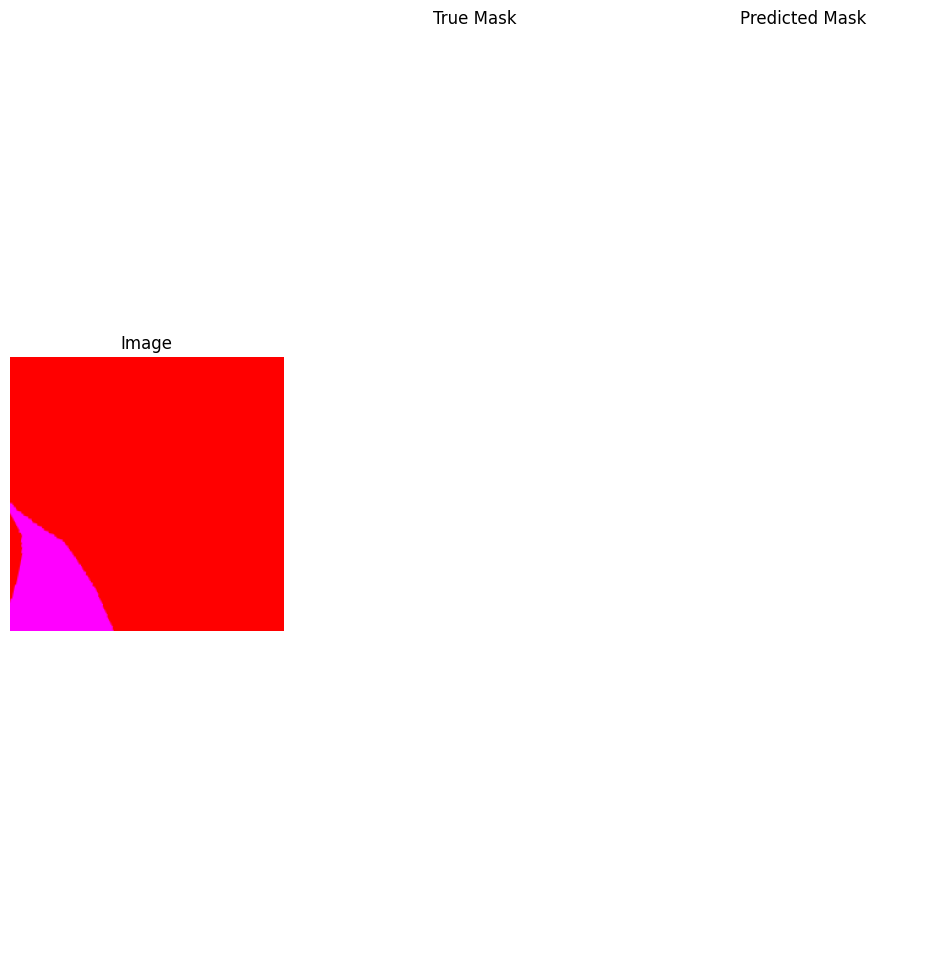

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step


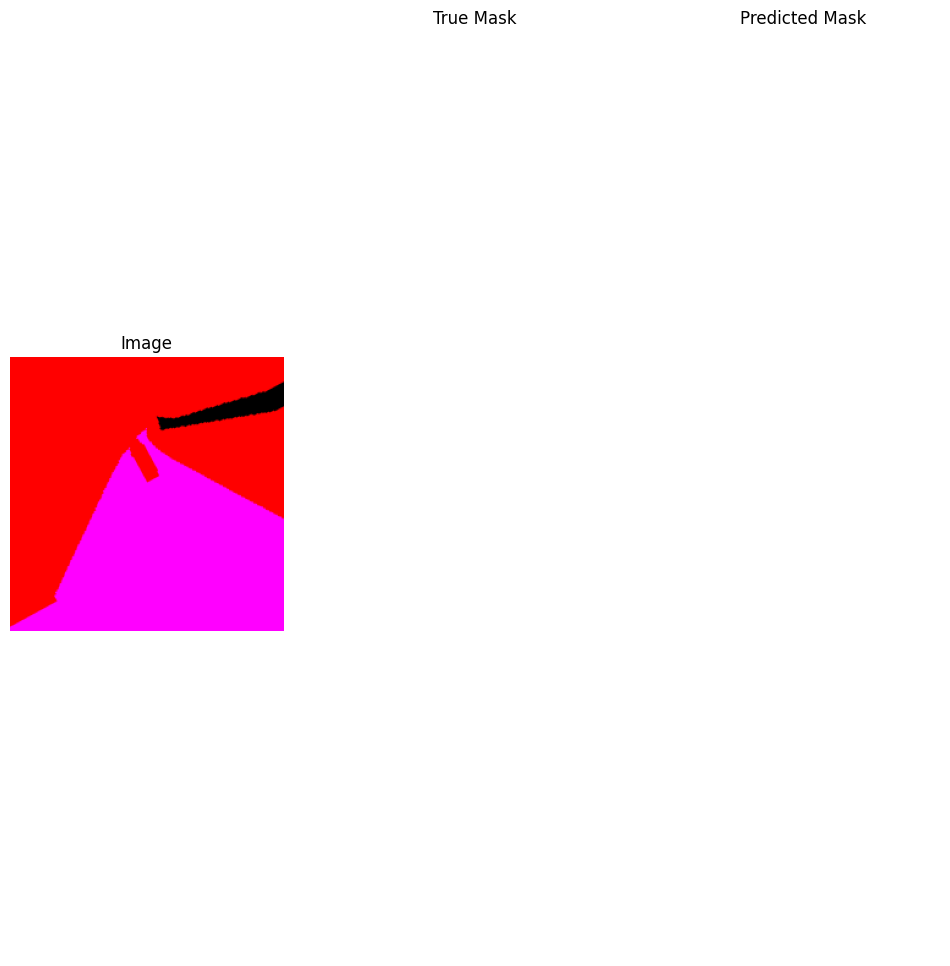

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step


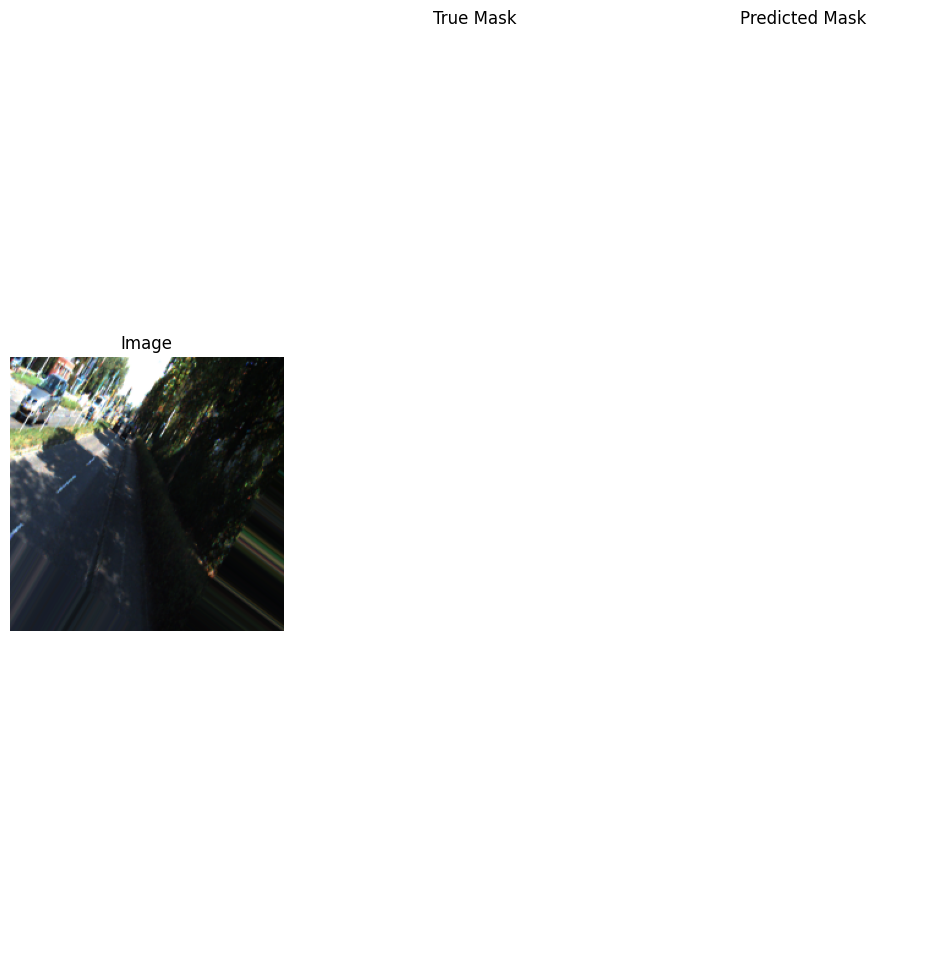

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


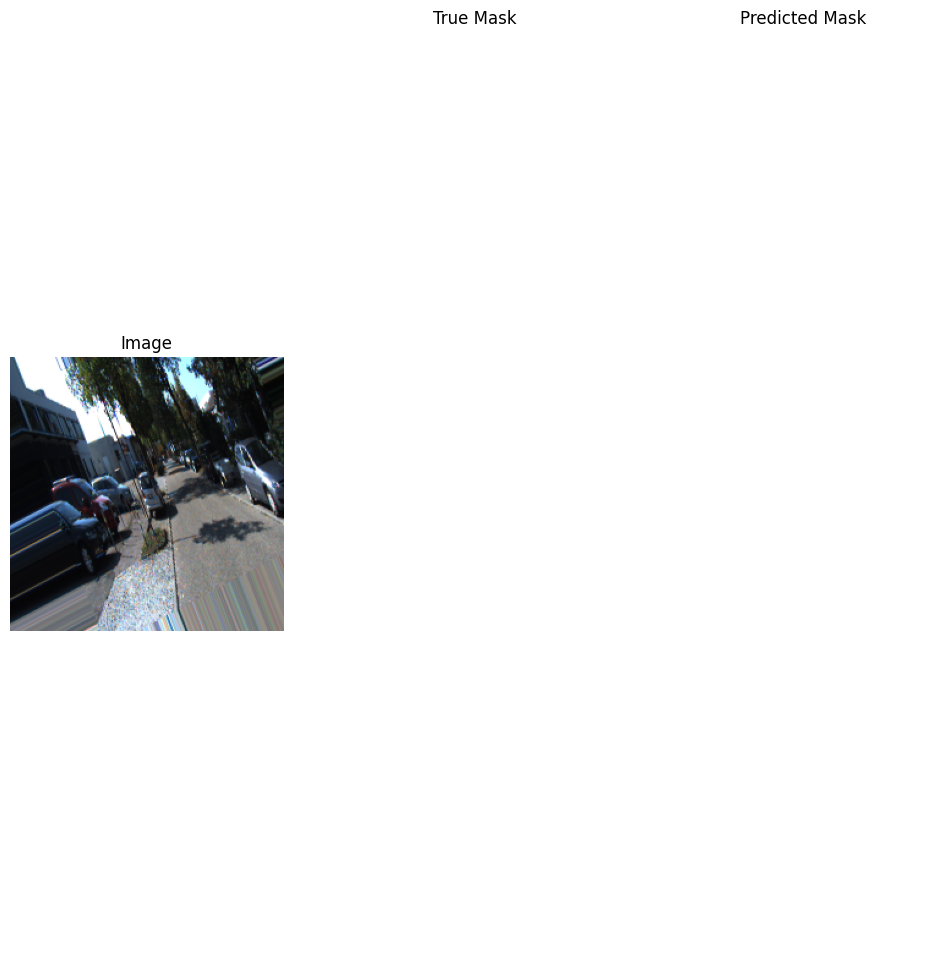

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step


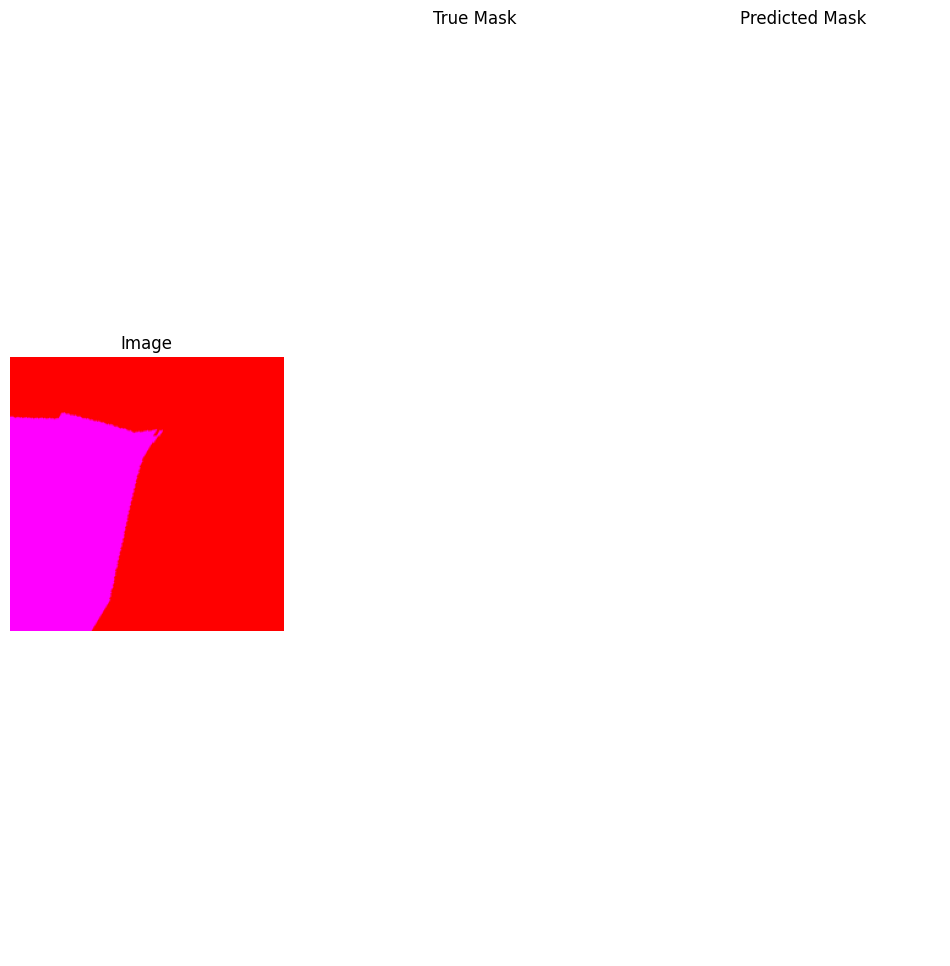

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


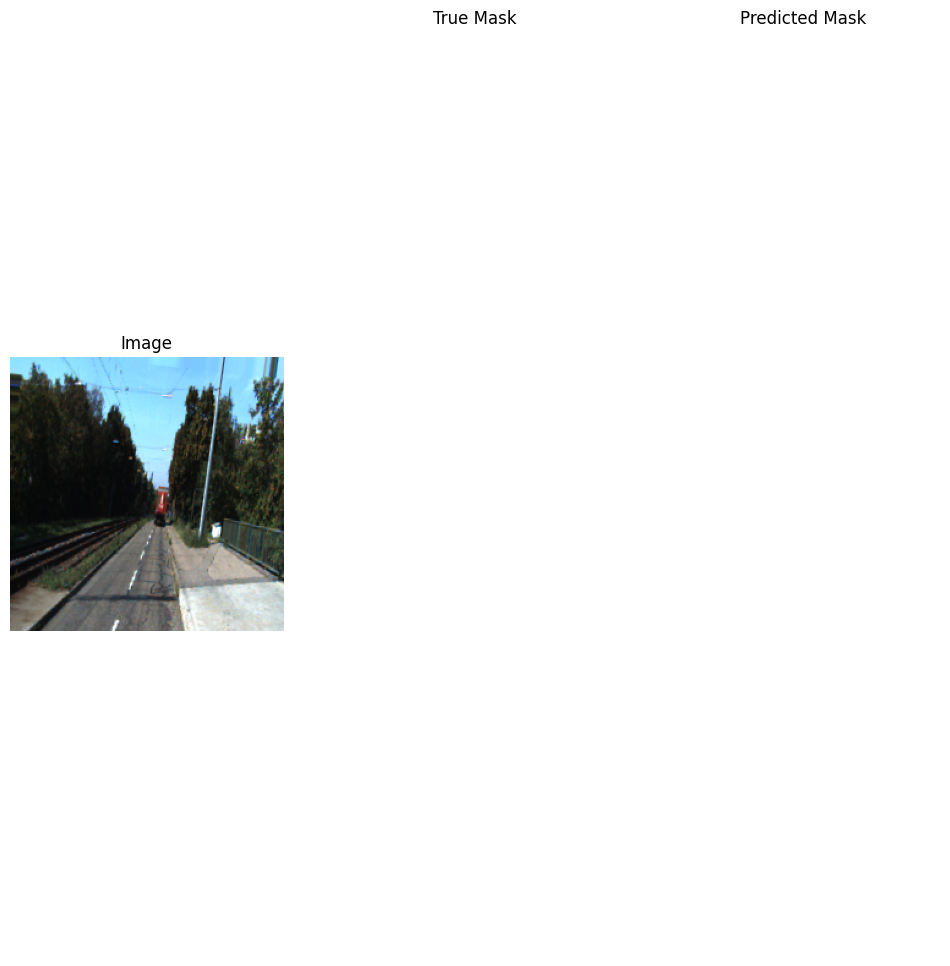

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


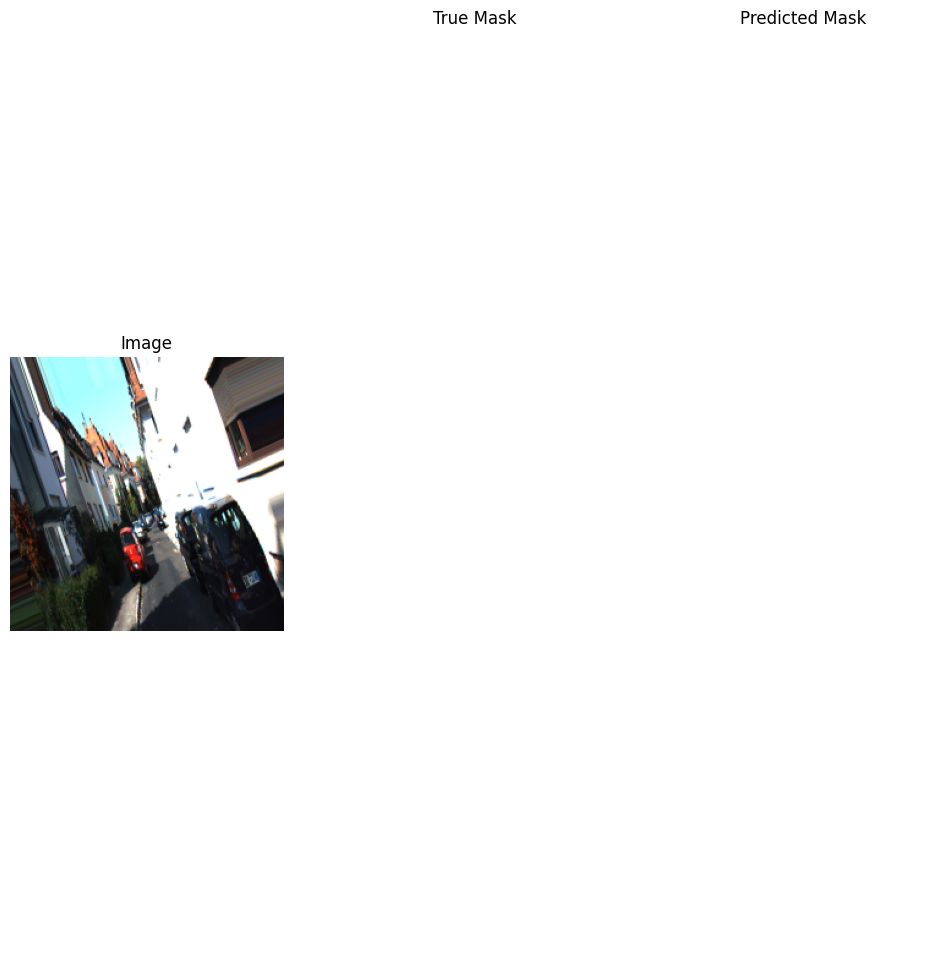

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step


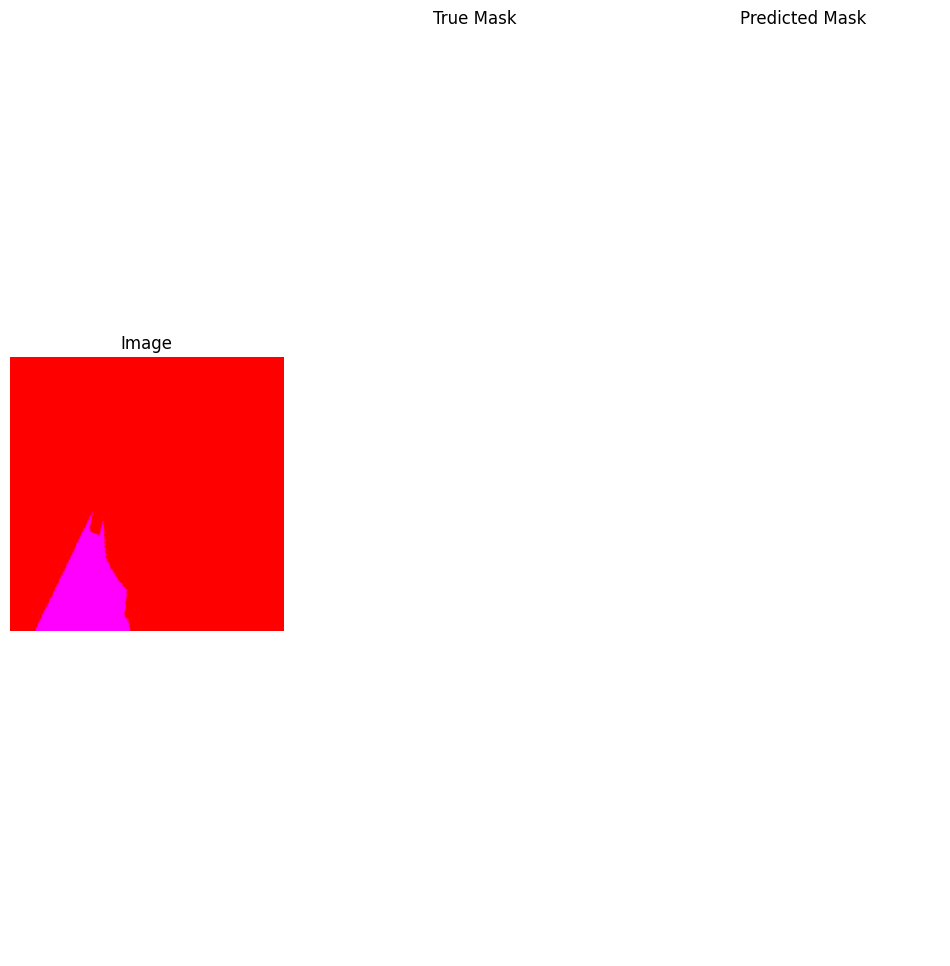

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


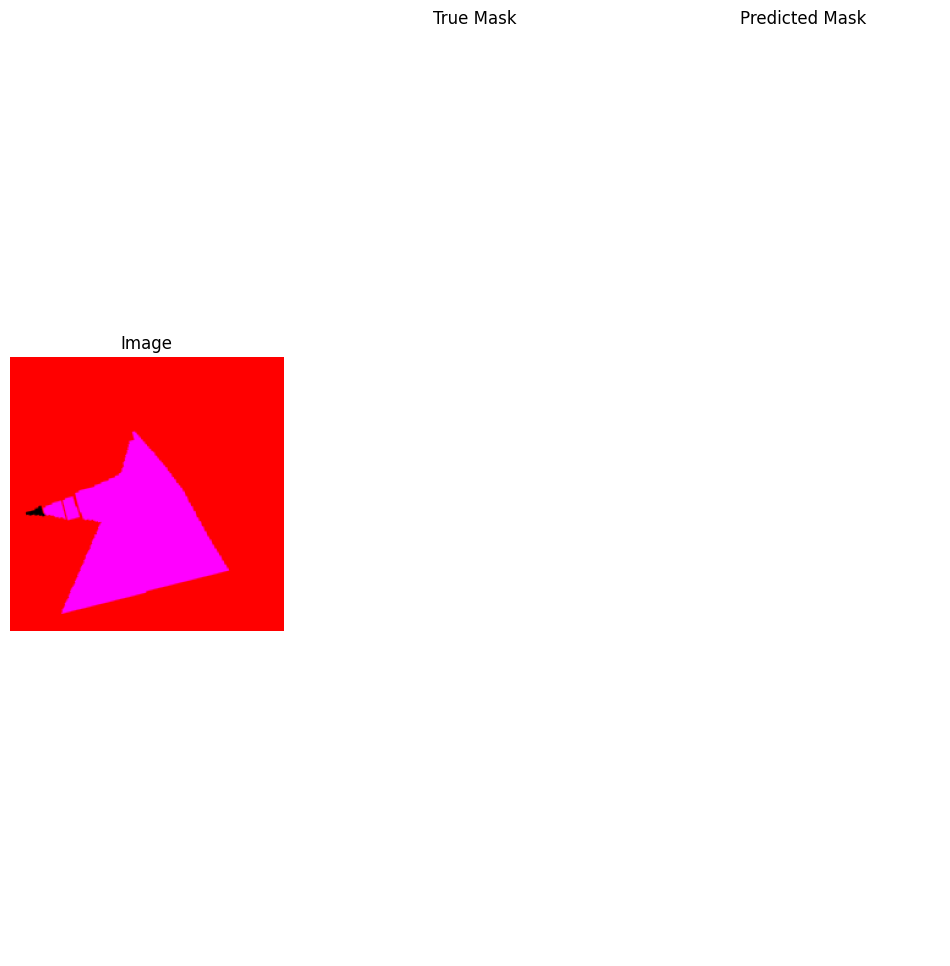

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


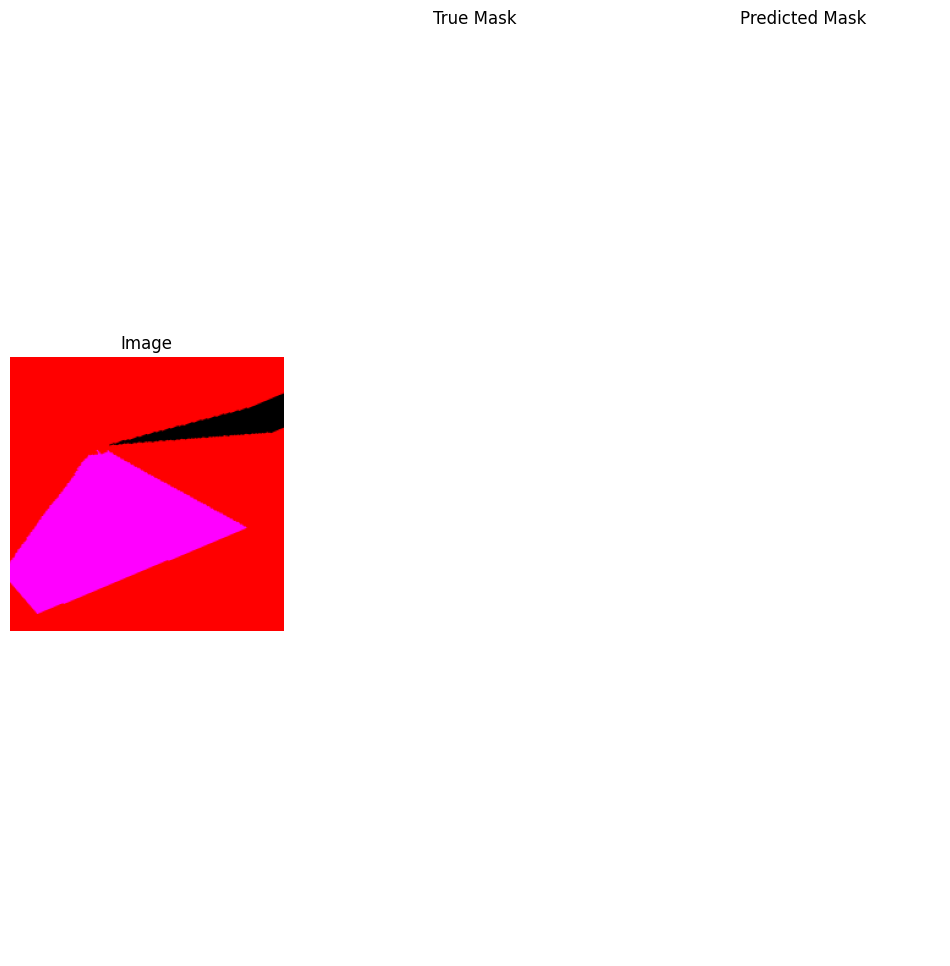

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step


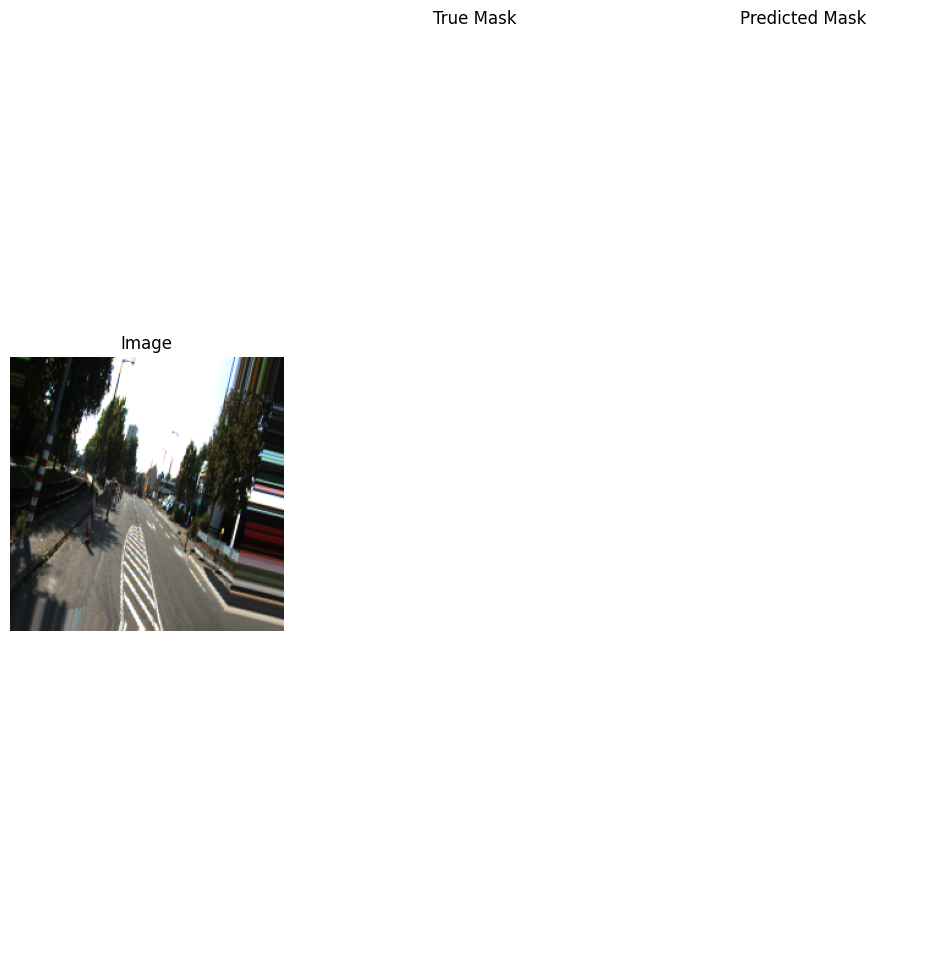

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step


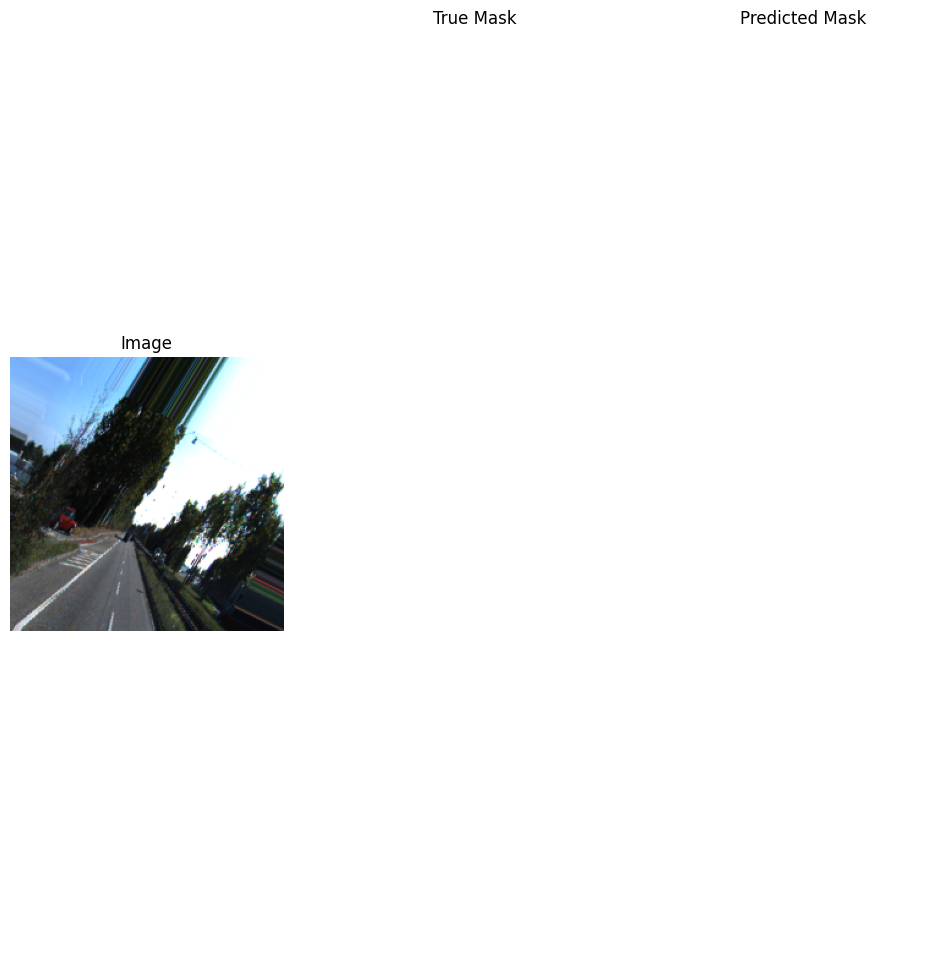

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step


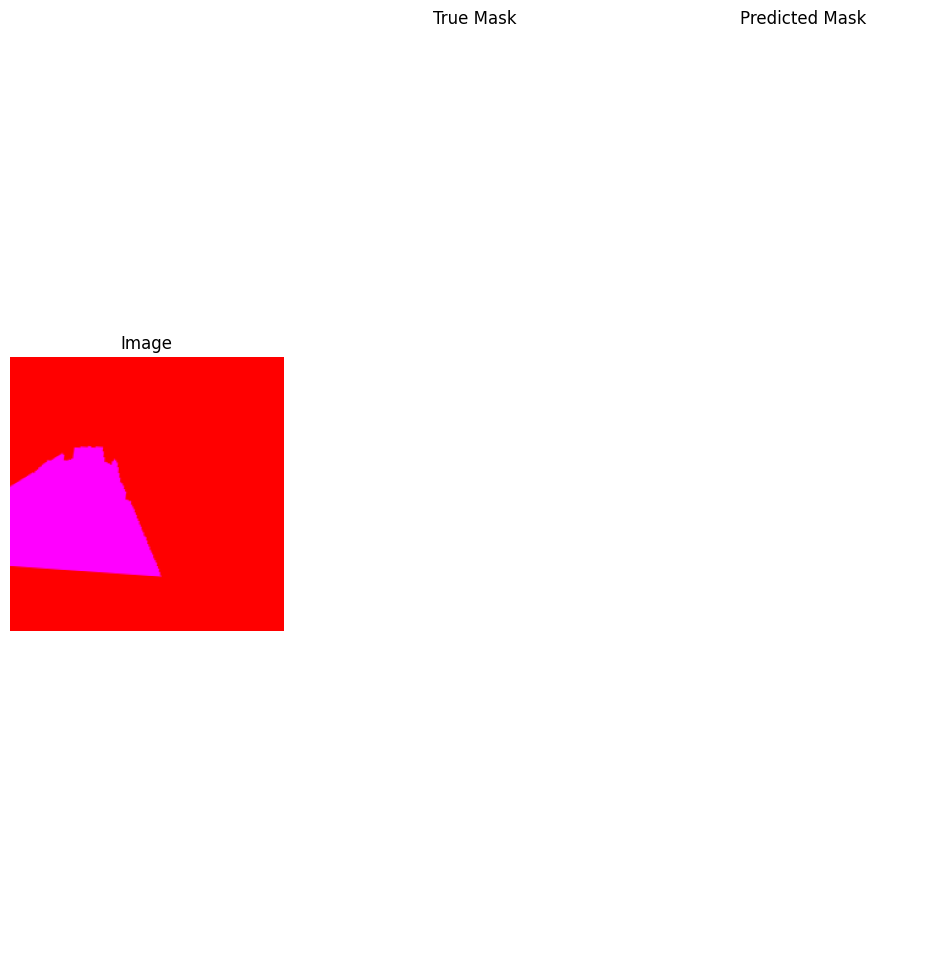

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step


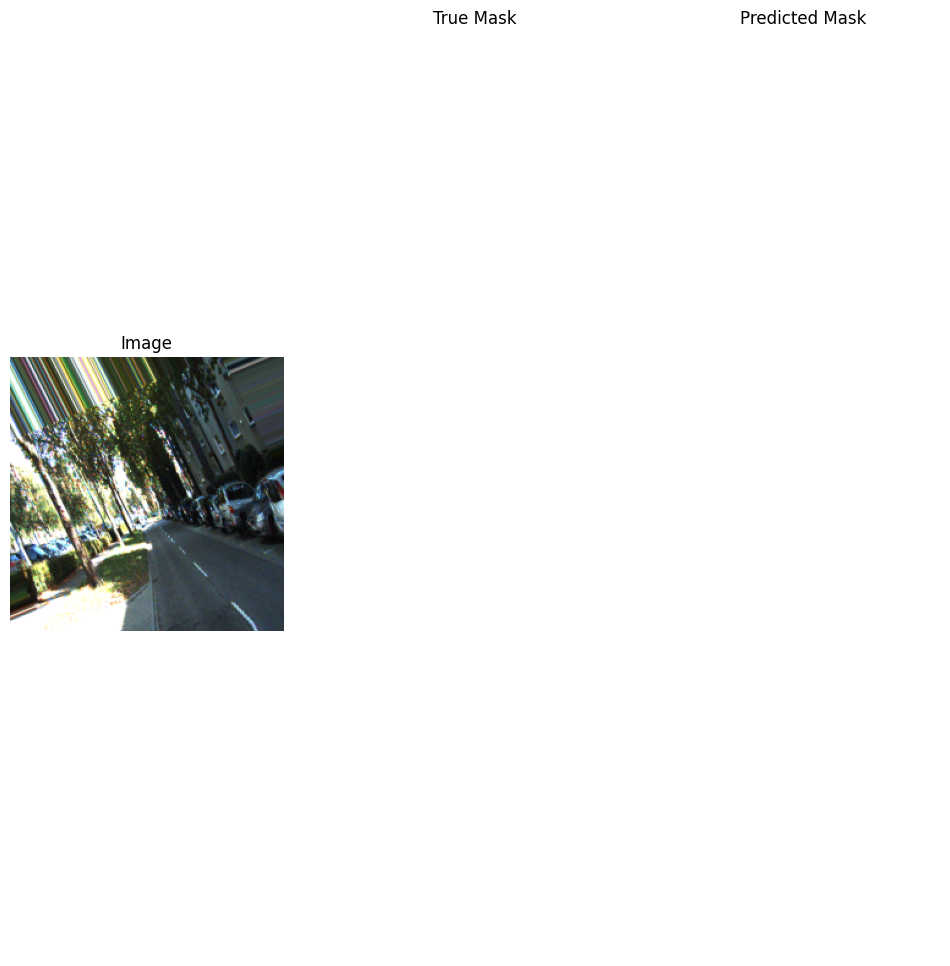

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step


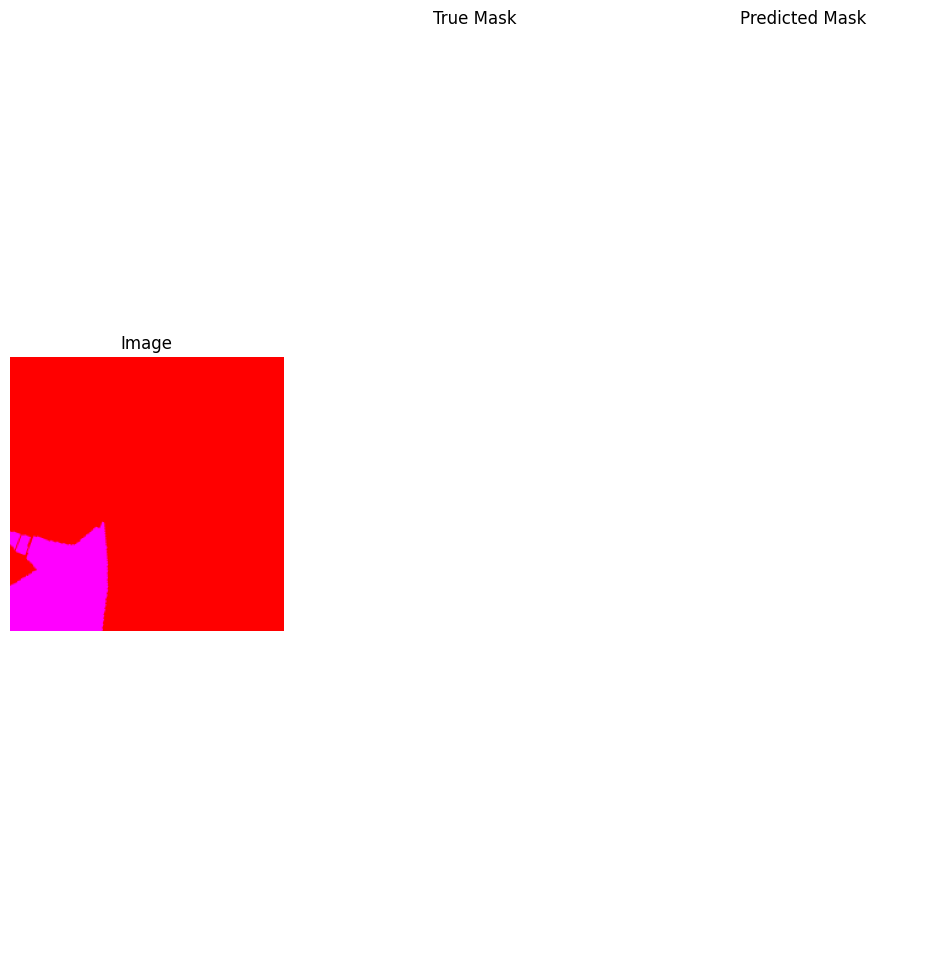

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


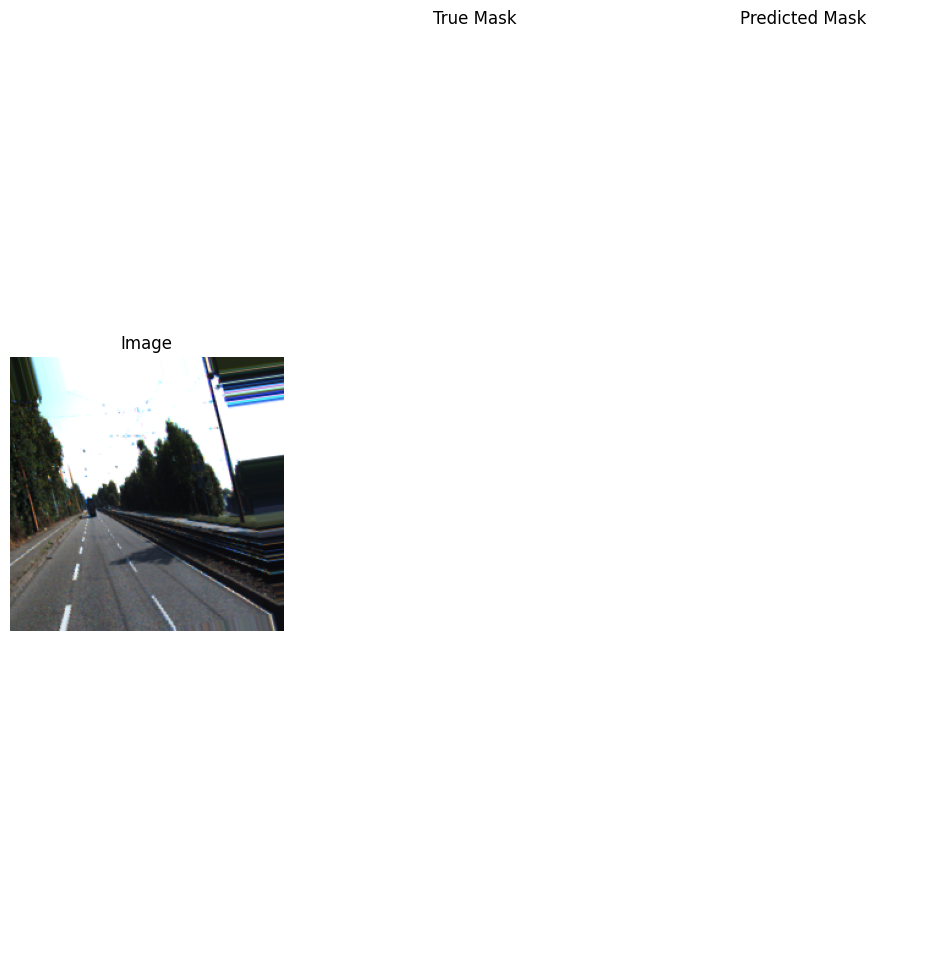

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step


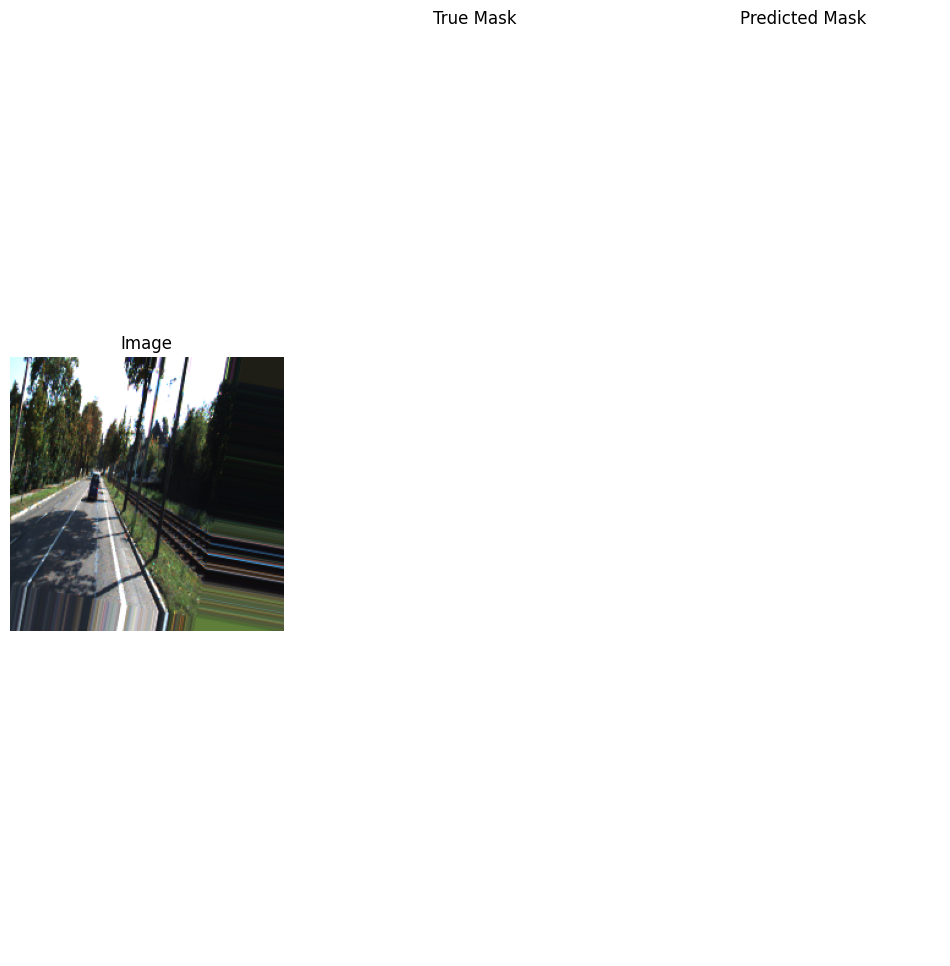

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step


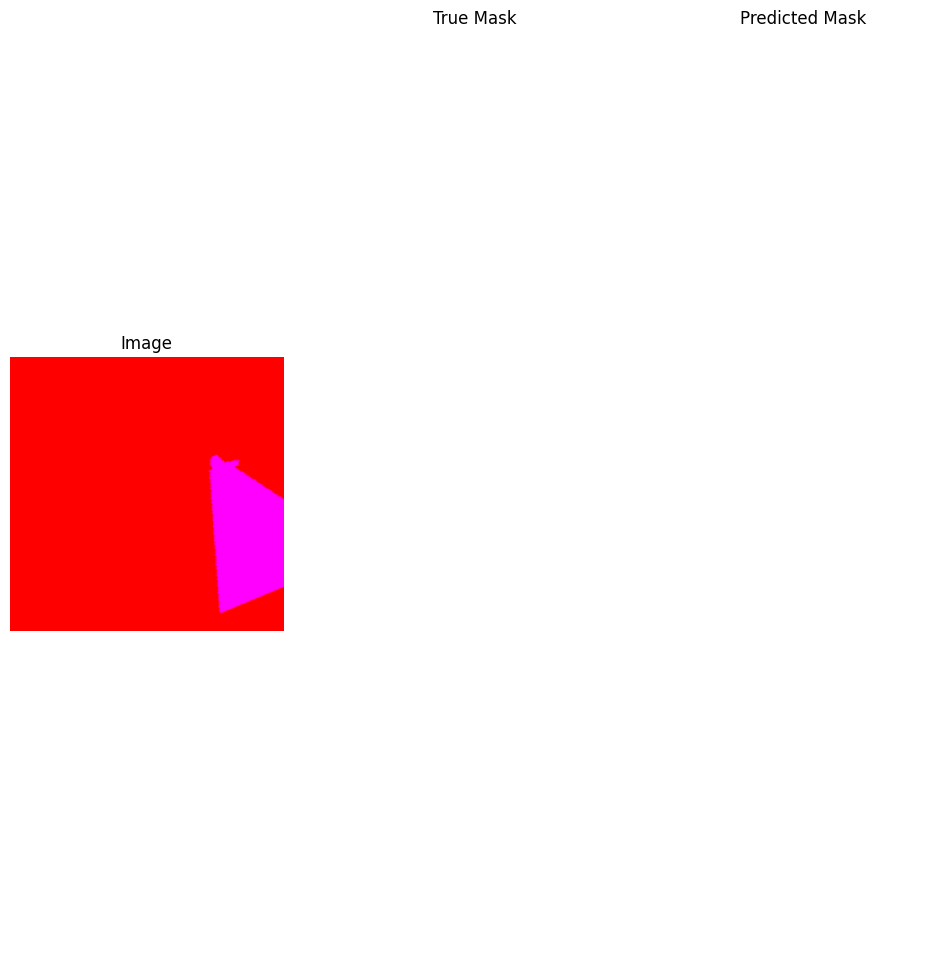

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step


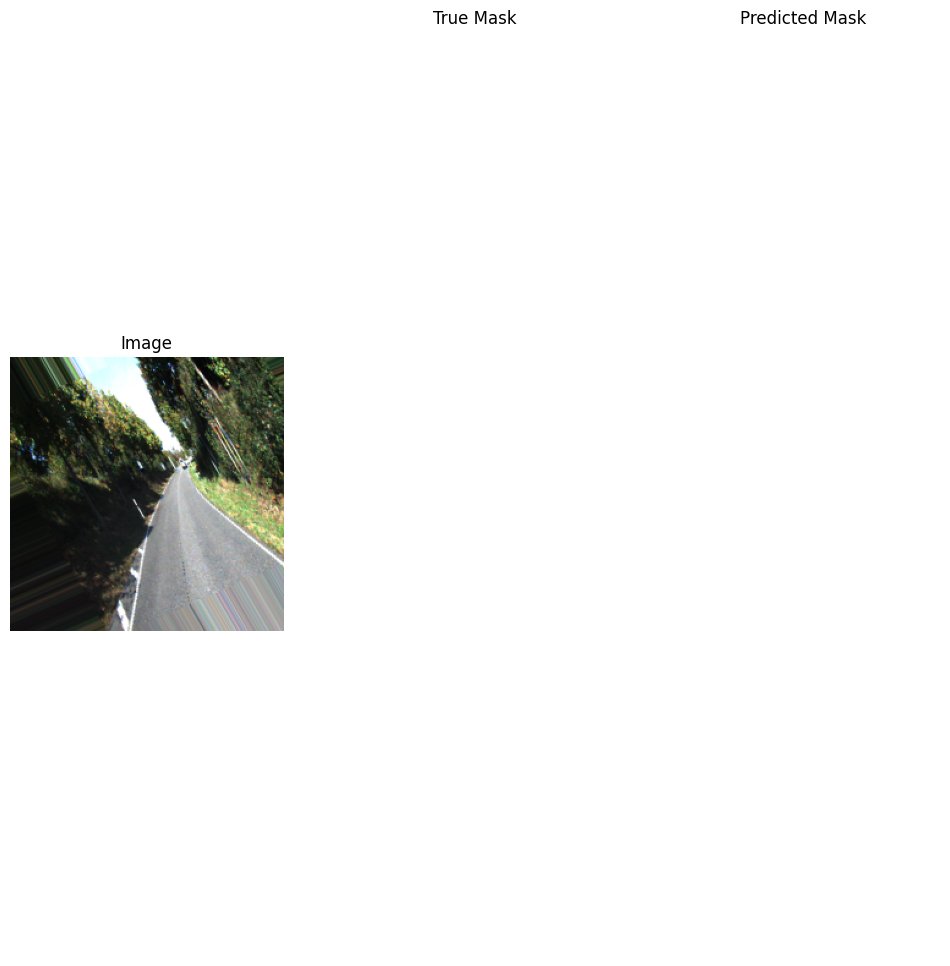

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


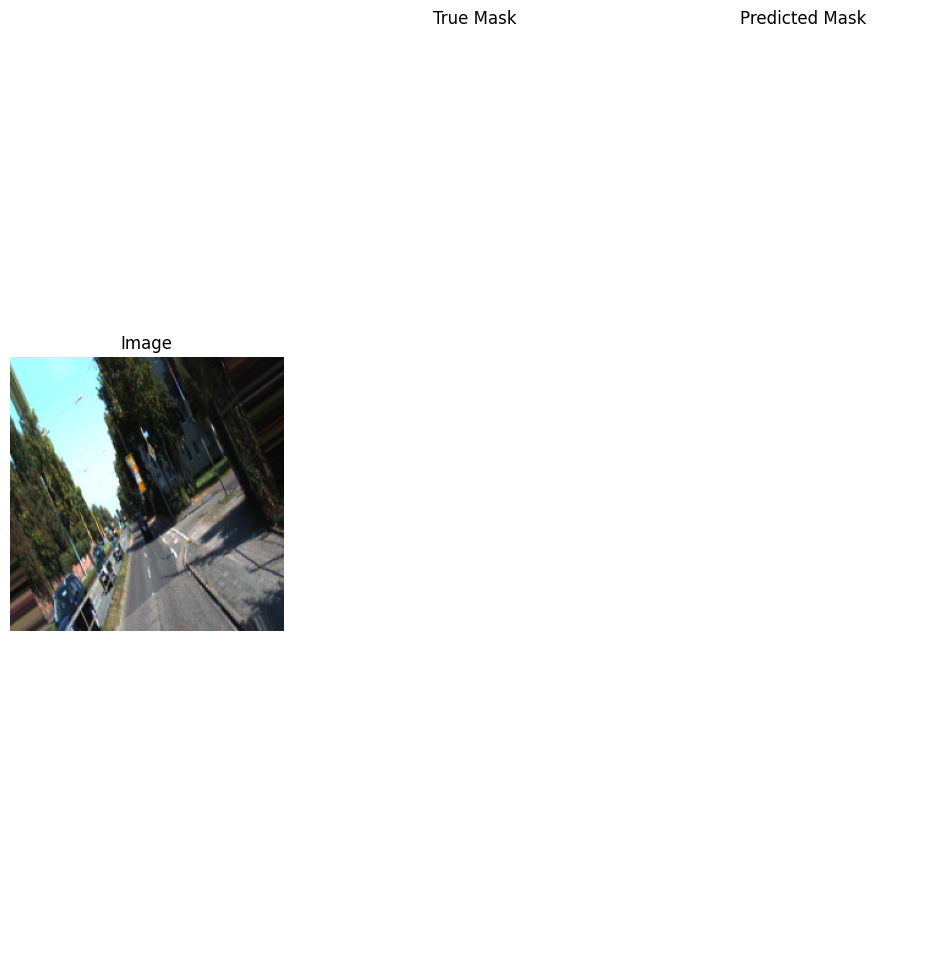

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to create a mask out of network prediction
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    # Round to closest
    pred_mask = tf.math.round(pred_mask)

    # [IMG_SIZE, IMG_SIZE] -> [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

# Function to show predictions
def show_predictions(dataset=None, num=1):
    if dataset:
        # Predict and show image from input dataset
        for image, mask in dataset:
            # Use the first image and mask from the batch
            pred_mask = model.predict(image)
            display_sample(image[0], mask[0], create_mask(pred_mask)[0])
    else:
        # Predict and show the sample image
        inference = model.predict(sample_image)
        display_sample(sample_image[0], sample_mask[0], inference[0])

# Display sample images
def display_sample(image, true_mask, pred_mask):
    """
    Display the sample image, true mask, and predicted mask.
    Assumes image and mask are [height, width, 3] and [height, width, 1] respectively.
    """
    plt.figure(figsize=(12, 12))

    # Plot the image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis('off')

    # Plot the true mask
    plt.subplot(1, 3, 2)
    #plt.imshow(true_mask.squeeze(), cmap='gray')  # Remove the extra dimension
    plt.title("True Mask")
    plt.axis('off')

    # Plot the predicted mask
    plt.subplot(1, 3, 3)
    #plt.imshow(pred_mask.squeeze(), cmap='gray')  # Remove the extra dimension
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

# Assuming you are using ImageDataGenerator or a similar generator
train_generator = train_data_gen.flow_from_directory(
    '/root/.cache/kagglehub/datasets/sakshaymahna/kittiroadsegmentation/versions/1',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Call the function to show predictions
show_predictions(train_generator)

Found 539 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


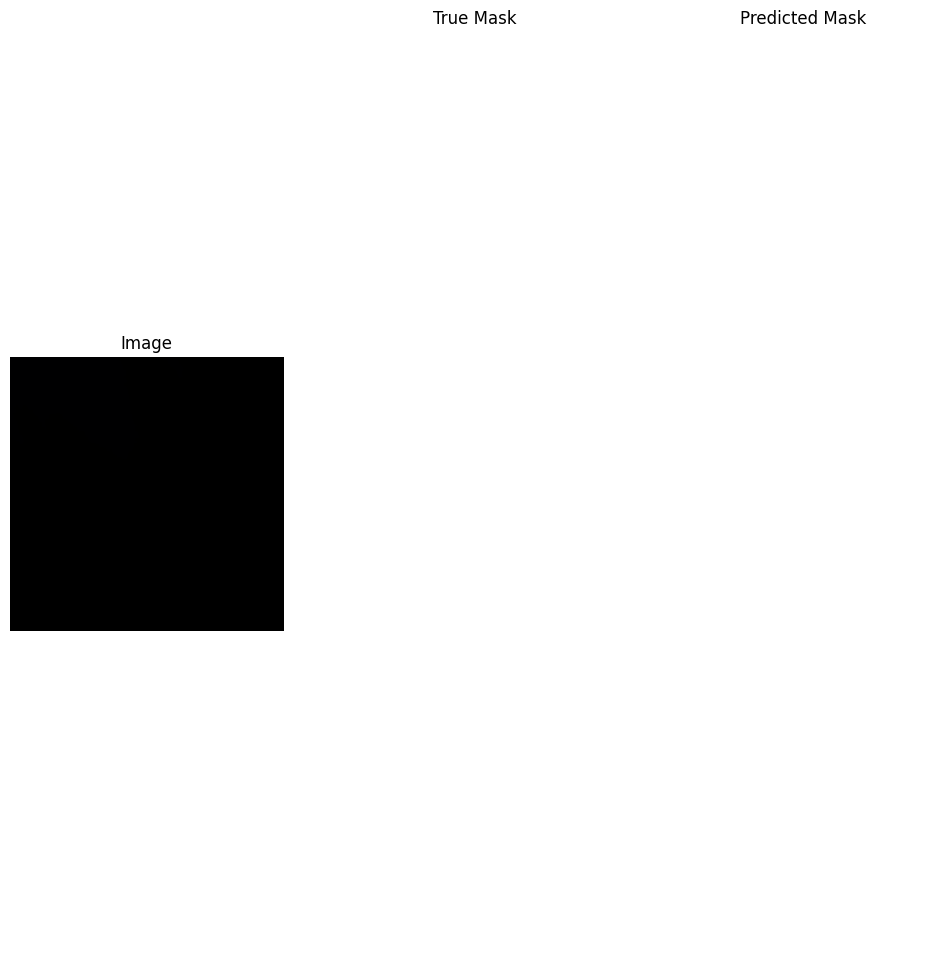

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to create a mask out of network prediction
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    # Round to closest
    pred_mask = tf.math.round(pred_mask)

    # [IMG_SIZE, IMG_SIZE] -> [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

# Function to show predictions
def show_predictions(dataset=None, num=1):
    if dataset:
        # Predict and show image from input dataset
        for image_batch, label_batch in dataset:
            # Use the first image and label from the batch
            image = image_batch[0]
            label = label_batch[0]  # If this is not a mask, adjust accordingly

            # Predict the mask
            pred_mask = model.predict(tf.expand_dims(image, axis=0))  # Add batch dimension
            pred_mask = create_mask(pred_mask[0])  # Remove batch dimension

            # Call display_sample with image, true label, and predicted mask
            display_sample(image, label, pred_mask)
            break  # Stop after one batch
    else:
        # Predict and show the sample image
        inference = model.predict(sample_image)
        display_sample(sample_image[0], sample_mask[0], inference[0])


# Display sample images
def display_sample(image, true_mask, pred_mask):
    plt.figure(figsize=(12, 12))

    # Plot the image
    plt.subplot(1, 3, 1)
    plt.imshow(image.astype('uint8'))  # Ensure dtype is compatible
    plt.title("Image")
    plt.axis('off')

    # Plot the true mask
    plt.subplot(1, 3, 2)
    if len(true_mask.shape) == 3:  # If true mask has an extra channel, squeeze it
        true_mask = true_mask.squeeze(-1)
    #plt.imshow(true_mask, cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    # Plot the predicted mask
    plt.subplot(1, 3, 3)
    #plt.imshow(pred_mask.squeeze(-1), cmap='gray')  # Remove extra dimensions
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

# Assuming you are using ImageDataGenerator or a similar generator
train_generator = train_data_gen.flow_from_directory(
    '/root/.cache/kagglehub/datasets/sakshaymahna/kittiroadsegmentation/versions/1',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Call the function to show predictions
show_predictions(train_generator)  # Pass the generator directly


### Train Model

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from keras import callbacks

# Callbacks and Logs
class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    DisplayCallback(),
    callbacks.TensorBoard(logdir, histogram_freq = -1),
    callbacks.EarlyStopping(patience = 10, verbose = 1),
    callbacks.ModelCheckpoint('best_model.keras', verbose = 1, save_best_only = True)
]

# Set Variables
EPOCHS = 50
STEPS_PER_EPOCH = 231 // 32
VALIDATION_STEPS = 28 // 32

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step


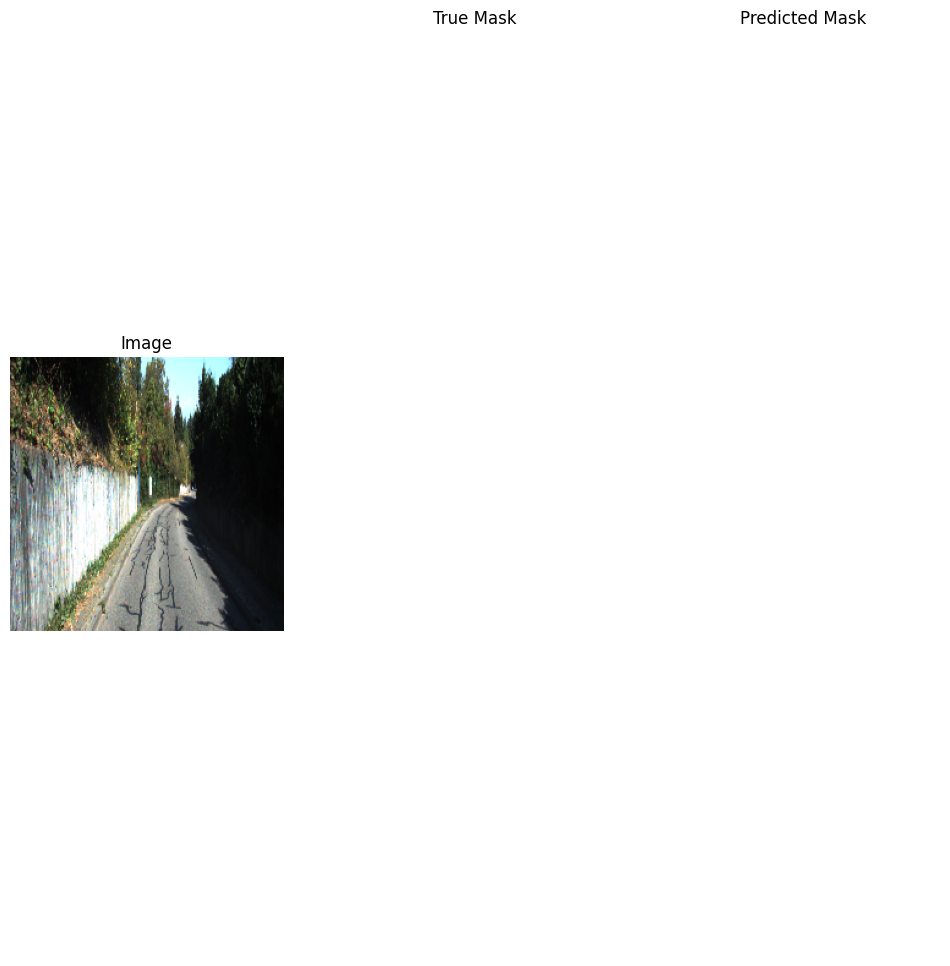


Sample Prediction after epoch 11


Epoch 11: val_loss did not improve from 0.00000
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 11: early stopping


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use the appropriate loss for binary classification
              metrics=['accuracy'])
model_history = model.fit(train_generator, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data = val_generator,
                          validation_steps=VALIDATION_STEPS,
                          callbacks = callbacks)

## Testing (Test Dataset)

In [ ]:
# Function to calculate mask over image
def weighted_img(img, initial_img, α=1., β=0.5, γ=0.):
    if img.shape != initial_img.shape:
        raise ValueError("Images must have the same shape")

    # Ensure data types are compatible
    if img.dtype != initial_img.dtype:
        img = img.astype(initial_img.dtype)
    return cv2.addWeighted(initial_img, α, img, β, γ)

# Function to process an individual image and it's mask
def process_image_mask(image, mask):
    # Round to closest
    mask = tf.math.round(mask)

    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image))
    mask = np.asarray(mask, np.float32)

    # Convert to image image
    image = np.asarray(image, np.float32)

    # Get the final image
    final_image = weighted_img(mask, image)

    return final_image

In [ ]:
# Function to save predictions
def save_predictions(dataset):
    # Predict and save image the from input dataset
    index = 0
    for batch_image, batch_mask in dataset:
        for image, mask in zip(batch_image, batch_mask):
            print(f"Processing image : {index}")
            pred_mask = model.predict(tf.expand_dims(image, axis = 0))
            save_sample([image, process_image_mask(image, pred_mask[0])], index)
            index += 1

# Function to save the images as a plot
def save_sample(display_list, index):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.savefig(f"outputs/{index}.png")
    plt.show()

In [ ]:
import os

# Check if the directory exists before attempting to create it
if not os.path.exists("output"):
    os.mkdir("output")

#save_predictions(dataset['test'])

## Testing (Videos)

In [ ]:
# Function to view video
def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    from IPython.display import HTML
    return HTML(html)

In [ ]:
def process_image(image):
    # Define the constants
    IMG_SIZE = 224  # Example size
    output_size = (1280, 720)  # Final output resolution

    # Preprocess the input image
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    # Predict the binary mask
    pred_mask = model.predict(np.expand_dims(image, axis=0))
    mask = np.round(pred_mask[0])  # Assuming sigmoid output, round to binary

    # Convert binary mask to 3-channel (red overlay)
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image)) * 255
    mask = np.asarray(mask, np.uint8)

    # Blend the mask with the original image
    final_image = weighted_img(mask, image)

    # Resize to the final resolution
    final_image = cv2.resize(final_image, output_size)

    return final_image


In [ ]:
# Make a new directory


### Project Video

In [ ]:
# # Creating a VideoCapture object to read the video
# project_video = "challenge.mp4"
# original_video = cv2.VideoCapture(test_data_dir + project_video)
# frame_width = int(original_video.get(3))
# frame_height = int(original_video.get(4))

# # Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
# fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
# fps = 60
# #output_path = "videos/" + project_video
# output = cv2.VideoWriter("/videos" + project_video, fourcc, fps, (frame_width,frame_height))

# # Process Video
# while(original_video.isOpened()):
#     ret, frame = original_video.read()

#     if ret == True:
#         # Write the frame into the file 'output.avi'
#         output.write(process_image(frame))

#     else:
#         break

# # When everything done, release the video capture and video write objects
# original_video.release()
# output.release()
# #play("videos/" + project_video)
# os.getcwd()

'/content'

In [ ]:
# output = cv2.VideoWriter("/videos" + project_video, fourcc, fps, (frame_width,frame_height))
# play("videos/" + project_video)
# os.getcwd()

In [ ]:
import cv2
import os
from base64 import b64encode

def play(filename):
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File not found: {filename}")
    video = open(filename, 'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html = f'<video width=1000 controls autoplay loop><source src="{src}" type="video/mp4"></video>'
    from IPython.display import HTML
    return HTML(html)

# Parameters
project_video = "challenge.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Replace 'mp4v' with your codec if needed
fps = 30
frame_width = 640
frame_height = 480

# Ensure the 'videos' directory exists
if not os.path.exists("videos"):
    os.makedirs("videos")

# Create video writer
output_path = "videos/" + project_video
output = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Check if VideoWriter initialized successfully
if not output.isOpened():
    raise ValueError("Failed to initialize cv2.VideoWriter. Check the path, codec, or resolution.")

# Example: Write a few dummy frames to the video
for _ in range(100):  # Generate 100 frames
    frame = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)  # Replace with actual frame
    output.write(frame)

# Release the video writer
output.release()

# Play the video
play(output_path)


In [ ]:
# import os

# # Relative path to the directory
# relative_directory = "/videos"

# # Get the absolute path
# absolute_path = os.path.abspath(relative_directory)
# print("Absolute Path:", absolute_path)


Absolute Path: /videos


In [ ]:
#file_path = os.path.abspath("videos/challenge.mp4")

play(output_path)

### Challenge Video

In [ ]:
# # Creating a VideoCapture object to read the video
# project_video = "challenge.mp4"
# original_video = cv2.VideoCapture(test_data_dir + project_video)
# frame_width = int(original_video.get(3))
# frame_height = int(original_video.get(4))

# # Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
# fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
# fps = 60
# output = cv2.VideoWriter("/content" + project_video, fourcc, fps, (frame_width,frame_height))

# # Process Video
# while(original_video.isOpened()):
#     ret, frame = original_video.read()

#     if ret == True:
#         # Write the frame into the file 'output.avi'
#         output.write(process_image(frame))

#     else:
#         break

# # When everything done, release the video capture and video write objects
# original_video.release()
# output.release()

In [ ]:
# play("/content" + project_video)

FileNotFoundError: [Errno 2] No such file or directory: '/content challenge.mp4'

### Challenge Video 2

In [ ]:
import cv2
import os
from base64 import b64encode

def play(filename):
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File not found: {filename}")
    video = open(filename, 'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html = f'<video width=1000 controls autoplay loop><source src="{src}" type="video/mp4"></video>'
    from IPython.display import HTML
    return HTML(html)

# Parameters
project_video = "challenge_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Replace 'mp4v' with your codec if needed
fps = 30
frame_width = 640
frame_height = 480

# Ensure the 'videos' directory exists
if not os.path.exists("videos"):
    os.makedirs("videos")

# Create video writer
output_path = "videos/" + project_video
output = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Check if VideoWriter initialized successfully
if not output.isOpened():
    raise ValueError("Failed to initialize cv2.VideoWriter. Check the path, codec, or resolution.")

# Example: Write a few dummy frames to the video
for _ in range(100):  # Generate 100 frames
    frame = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)  # Replace with actual frame
    output.write(frame)

# Release the video writer
output.release()

# Play the video
play(output_path)


In [ ]:
# Creating a VideoCapture object to read the video
project_video = "challenge_video.mp4"
original_video = cv2.VideoCapture(test_data_dir + project_video)
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("videos/" + project_video, fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))

    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()

### Harder Challenge Video

In [ ]:
import cv2
import os
from base64 import b64encode

def play(filename):
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File not found: {filename}")
    video = open(filename, 'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html = f'<video width=1000 controls autoplay loop><source src="{src}" type="video/mp4"></video>'
    from IPython.display import HTML
    return HTML(html)

# Parameters
project_video = "harder_challenge_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Replace 'mp4v' with your codec if needed
fps = 30
frame_width = 640
frame_height = 480

# Ensure the 'videos' directory exists
if not os.path.exists("videos"):
    os.makedirs("videos")

# Create video writer
output_path = "videos/" + project_video
output = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Check if VideoWriter initialized successfully
if not output.isOpened():
    raise ValueError("Failed to initialize cv2.VideoWriter. Check the path, codec, or resolution.")

# Example: Write a few dummy frames to the video
for _ in range(100):  # Generate 100 frames
    frame = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)  # Replace with actual frame
    output.write(frame)

# Release the video writer
output.release()

# Play the video
play(output_path)


In [ ]:
# Creating a VideoCapture object to read the video
project_video = "harder_challenge_video.mp4"
original_video = cv2.VideoCapture(test_data_dir + project_video)
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("videos/" + project_video, fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))

    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()

In [ ]:
os.chdir("/content")
os.getcwd()

#play("videos/" + project_video)

'/content'

## References

- [Kitti Dataset Processing](http://ronny.rest/blog/post_2017_09_06_kitti_road_data/)
- [Image Segmentation on Keras](https://yann-leguilly.gitlab.io/post/2019-12-14-tensorflow-tfdata-segmentation/)